#### Code for the Poster Contribution at V-VSS 2021
##### by Clara Kuper
##### April 2021

In this code, I will review and discuss the data from a pilot experiment. In the pilot, I tested 4 subjects in 3 sessions each. Substantial parts of this analysis have been presented at V-VSS 2021 at poster A 133. This notebook entails more analysis and information than included in the poster. Figures used in the poster are marked as 
### V-VSS 2021 Figure 
and the corresponding analysis is marked as 
### V-VSS 2021 Analysis

In this notebook, I will follow these steps:

0. Load the needed libaries and data files

1. review the data 
    
    a. describe size, structure
    
    b. show basic behavioural measurements
    
    
2. describe different strategies to solve the task
    
    a. compare ideal observers using different strategies
    
    b. fit linear models to models the response type (go/ no-go).
    
    
3. describe the time windows that had an influence on the response
    
    a. modeled forwards, from the start of each trial
    
    b. modeled backwards, from the response in each trial
    
    
4. fit linear models to the reaction time
5. describe 3 mechanisms, based on drift diffusion models, and compare their simulated output to 3.

In [1]:
## libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import math
import pickle

## filter warnings
import os
import re
import warnings
warnings.filterwarnings("ignore")

## import R
## we will use the R framework to fit mixed effect models
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.0.3'

## pymer is built on the lme4 package in R
import pymer4
from pymer4.models import Lmer, Lm

## import the pyDDM library
from ddm import Fittable, Model, Sample, Bound
from ddm.models import LossRobustBIC, DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, Drift
from ddm.functions import fit_adjust_model, display_model
import ddm.plot

## data paths
path_clean = '../2_cleaned/'
path_figs = '../3_Figures/'
path_models = '../2-3_Fitted/pyDDM_Models/'

# data files
# the "verbose" data file has long, but nicely interpretable variable names
df = pd.read_csv(path_clean+'df_verbose.csv', sep = ',')
# compute if the response was correct or incorrect from the given data
df['answer'] = 1 - (abs(df.goResp - df.hitGoal))
df['subject'].replace({'AD': 'o1', 'AE': 'o2', 'AF': 'o3', 'AG': 'o4'}, inplace = True)

df.to_csv(path_clean+'dataframe_short.csv', header = True, index = False)

long_df = pd.read_csv(path_clean+'long_data.csv', sep = ',')
# transform the timing column in the second space
long_df['sampleTimeSecGo'] = long_df.sampleTimeMsGo/1000
# get the timing relative to the response
long_df['sampleTimeSecResp'] = long_df.sampleTimeSecGo - long_df.rea_time
long_df['subject'].replace({'AD': 'o1', 'AE': 'o2', 'AF': 'o3', 'AG': 'o4'}, inplace = True)

long_df.to_csv(path_clean+'dataframe_long.csv', header = True, index = False)



## when fitting reaction times, we will need only the trial with "go" responses
go_df = df[df.goResp == 1]
nogo_df = df[df.goResp == 0]

## define colormaps for plotting
# subjects cm
s_cm = plt.cm.get_cmap('summer')(np.linspace(0,0.8, len(np.unique(long_df.subject))))
# go/nogo cm
g_cm = plt.cm.get_cmap('BrBG')
# correct/incorrect response (performance)
p_cm = plt.cm.get_cmap('RdYlGn')
# trial condition cmap(hit, pass)
c_cm = plt.cm.get_cmap('PuOr')
# time window cmap
t_cm_cont =  plt.cm.get_cmap('Blues_r')

t_cm = t_cm_cont(np.linspace(0, 0.8, len(np.unique(long_df.sampleID))))

# set fontsize for matplotlib
font = {'weight' : 'normal',
        'size'   : 25}
plt.rc('font', **font)
plt.rcParams['legend.title_fontsize'] = 25
plt.rcParams['legend.fontsize'] = 25

# standardize plot sizes:
cm = 1/2.54

height = 10 * cm
width = 10 * cm
gaps = 4 * cm

1. Data Review

Introduction to the task:
The observer is asked to decide if a moving stimulus (attacker) will intercept or pass a target range on the screen.
The target range is revealed gradually while the attacker is moving, by showing points (targets) within the target range.
A response has to be given before the attacker reaches the target range, either by moving the hand from the keyboad to the screen and touching the estimated location of the target range, or by keeping the hand on the keyboard.

This renderes the experiment a classsical go/nogo task.
Below, I include a gif of one trial.
![TrialLocal](../../0_Concept/Visuals/Trial/example_trial.gif "Example Trial")

In the real experiment, the dots were smaller and the attacker travelled over a longer distance.
As you can see, one trial is characterized by 6 different events (new targets on the screen) that appear at different times. These targets have certain properties, such as the vertical distance from the attacking stimulus.

In the data set below, each trial is represented in one column. Every property of a target at every new position are represented in columns labled _1 to _6. 

In the preprocessing, I cleaned trials with overly long or short reaction times (more than 3 std longer/shorter than the mean). Also, I already computed some new property values for the stimuli & a preliminary reverse correlation.

Every measure/column I include in this analysis will be discussed.

In [2]:
# print the data frame

print("This data frame has a size of {} rows and {} columns.".format(df.shape[0], df.shape[1]))
df

This data frame has a size of 9589 rows and 74 columns.


,goalPosDegCen,difficulty,in_out,up_down,samplePosDegCen_01,samplePosDegCen_02,samplePosDegCen_03,samplePosDegCen_04,samplePosDegCen_05,samplePosDegCen_06,...,sampleAccprobHit_04,sampleAccprobHit_05,sampleAccprobHit_06,sampleProbHit_01,sampleProbHit_02,sampleProbHit_03,sampleProbHit_04,sampleProbHit_05,sampleProbHit_06,answer
0,2,1.809975,1,-1,0.301258,3.225335,2.362545,1.703039,-0.261664,0.700806,...,0.190052,0.213758,0.213758,0.486096,0.120586,0.228435,0.310873,0.556461,0.436152,0
1,2,1.847432,-1,-1,-0.822462,5.460380,5.465482,0.879874,-0.565124,2.491225,...,1.000000,1.000000,1.000000,0.916263,0.298381,0.297744,0.870945,0.948431,0.669526,1
2,2,1.929658,-1,1,3.746282,0.868587,-1.166560,-1.477911,1.467197,5.791083,...,0.883255,0.883255,1.000000,0.959492,0.599781,0.345387,0.306468,0.674607,0.784907,1
3,-2,1.834521,-1,-1,-3.330029,-0.337660,0.971259,1.627050,-5.873847,1.302279,...,0.725445,1.000000,1.000000,0.895569,0.521523,0.357908,0.275934,0.786454,0.316530,1
4,4,1.920750,1,1,4.869227,3.625997,5.868832,5.287595,5.330901,2.434693,...,0.296196,0.296196,0.112562,0.368560,0.213156,0.493510,0.420856,0.426269,0.064243,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9584,2,1.982123,-1,1,4.456436,2.318772,-0.742732,4.046430,2.954920,4.563570,...,1.000000,1.000000,1.000000,0.945180,0.787612,0.404924,0.996431,0.867130,0.931788,1
9585,4,1.899154,-1,-1,0.063404,5.288069,6.721251,6.232631,6.704509,0.875458,...,1.000000,1.000000,1.000000,0.770531,0.576386,0.397238,0.458315,0.399331,0.872038,1
9586,0,1.961706,-1,1,0.708903,-0.927350,-0.761635,-2.777155,-3.261583,0.442904,...,0.705492,0.670087,0.670087,0.833826,0.629295,0.650009,0.398069,0.337515,0.800576,1
9587,-2,1.844734,-1,1,0.183733,-3.739433,-2.346879,-1.617489,-0.286732,-1.663975,...,1.000000,1.000000,1.000000,0.996442,0.513163,0.687232,0.778406,0.944750,0.772595,1


In [3]:
# group the data by subject and session & show how often they generated a "go" response
summary_gR_bSS = df.groupby(['subject','session']).describe().goResp
summary_gR_bSS

count      mean       std  min  25%  50%  75%  max
subject session                                                    
o1      1        800.0  0.606250  0.488886  0.0  0.0  1.0  1.0  1.0
        2        800.0  0.522500  0.499806  0.0  0.0  1.0  1.0  1.0
        3        799.0  0.491865  0.500247  0.0  0.0  0.0  1.0  1.0
o2      1        796.0  0.430905  0.495514  0.0  0.0  0.0  1.0  1.0
        2        799.0  0.415519  0.493120  0.0  0.0  0.0  1.0  1.0
        3        797.0  0.432873  0.495785  0.0  0.0  0.0  1.0  1.0
o3      1        800.0  0.463750  0.498996  0.0  0.0  0.0  1.0  1.0
        2        798.0  0.431078  0.495538  0.0  0.0  0.0  1.0  1.0
        3        800.0  0.441250  0.496847  0.0  0.0  0.0  1.0  1.0
o4      1        800.0  0.640000  0.480300  0.0  0.0  1.0  1.0  1.0
        2        800.0  0.531250  0.499335  0.0  0.0  1.0  1.0  1.0
        3        800.0  0.536250  0.498996  0.0  0.0  1.0  1.0  1.0

every subject ran 3 session with ~800 successfully completed trials in each. The maximum number of excluded trials was 4 in one session.

Subjects generated between 60 - 40 % go responses. A more interesting measure is how many correct responses were generated.

In [4]:
# retrieve the information if a response was correct 
# a response is correct, when there is no difference between goResponse (the subject response)
# and hitGoal (if the attacker hit the target area or not)
summary_a_bSS = df.groupby(['subject','session']).describe().answer
summary_a_bSS

count      mean       std  min  25%  50%  75%  max
subject session                                                    
o1      1        800.0  0.778750  0.415348  0.0  1.0  1.0  1.0  1.0
        2        800.0  0.842500  0.364499  0.0  1.0  1.0  1.0  1.0
        3        799.0  0.883605  0.320899  0.0  1.0  1.0  1.0  1.0
o2      1        796.0  0.868090  0.338605  0.0  1.0  1.0  1.0  1.0
        2        799.0  0.873592  0.332517  0.0  1.0  1.0  1.0  1.0
        3        797.0  0.872020  0.334277  0.0  1.0  1.0  1.0  1.0
o3      1        800.0  0.791250  0.406670  0.0  1.0  1.0  1.0  1.0
        2        798.0  0.829574  0.376242  0.0  1.0  1.0  1.0  1.0
        3        800.0  0.853750  0.353578  0.0  1.0  1.0  1.0  1.0
o4      1        800.0  0.755000  0.430356  0.0  1.0  1.0  1.0  1.0
        2        800.0  0.856250  0.351056  0.0  1.0  1.0  1.0  1.0
        3        800.0  0.881250  0.323696  0.0  1.0  1.0  1.0  1.0

All subjects achieved high performance on this task (between 75% and 88%)
To see, if this differs between go and noGo responses, we include the type of the task in the grouping

In [5]:
summary_a_bSSH = df.groupby(['subject','session','hitGoal']).describe().answer
summary_a_bSH = df.groupby(['subject','hitGoal']).describe().answer
summary_a_bSSH

count      mean       std  min  25%  50%  75%  max
subject session hitGoal                                                    
o1      1       0        400.0  0.672500  0.469889  0.0  0.0  1.0  1.0  1.0
                1        400.0  0.885000  0.319421  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.820000  0.384669  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.865000  0.342152  0.0  1.0  1.0  1.0  1.0
        3       0        399.0  0.892231  0.310478  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.875000  0.331133  0.0  1.0  1.0  1.0  1.0
o2      1       0        400.0  0.935000  0.246835  0.0  1.0  1.0  1.0  1.0
                1        396.0  0.800505  0.400126  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.957500  0.201980  0.0  1.0  1.0  1.0  1.0
                1        399.0  0.789474  0.408194  0.0  1.0  1.0  1.0  1.0
        3       0        400.0  0.937500  0.242365  0.0  1.0  1.0  1.0  1.0
                1        397.0  0.806045  0.395893  0.0  1.0  1.0  1.0  1.0
o3      1       0        400.0  0.827500  0.378288  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.755000  0.430626  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.897500  0.303685  0.0  1.0  1.0  1.0  1.0
                1        398.0  0.761307  0.426822  0.0  1.0  1.0  1.0  1.0
        3       0        400.0  0.912500  0.282920  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.795000  0.404207  0.0  1.0  1.0  1.0  1.0
o4      1       0        400.0  0.615000  0.487205  0.0  0.0  1.0  1.0  1.0
                1        400.0  0.895000  0.306937  0.0  1.0  1.0  1.0  1.0
        2       0        400.0  0.825000  0.380443  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.887500  0.316376  0.0  1.0  1.0  1.0  1.0
        3       0        400.0  0.845000  0.362358  0.0  1.0  1.0  1.0  1.0
                1        400.0  0.917500  0.275470  0.0  1.0  1.0  1.0  1.0

In [6]:
# finally, we want to look at the reaction time
summary_r_bSS = df.groupby(['subject','session']).describe().rea_time
summary_r_bSS

count      mean       std       min       25%       50%  \
subject session                                                            
o1      1        485.0  0.520437  0.086453  0.317108  0.450144  0.516454   
        2        418.0  0.529800  0.087098  0.308625  0.466004  0.516490   
        3        393.0  0.520102  0.080500  0.340964  0.457889  0.516084   
o2      1        343.0  0.518824  0.074193  0.349766  0.466352  0.499829   
        2        332.0  0.561288  0.068841  0.383147  0.514054  0.557913   
        3        345.0  0.535802  0.068189  0.408158  0.483221  0.516466   
o3      1        371.0  0.466831  0.104657  0.258133  0.387271  0.457863   
        2        344.0  0.462944  0.093811  0.290775  0.391250  0.450177   
        3        353.0  0.477539  0.090869  0.299756  0.407888  0.474843   
o4      1        512.0  0.646261  0.059979  0.433151  0.608061  0.649628   
        2        425.0  0.619411  0.052415  0.483152  0.582845  0.624387   
        3        429.0  0.616941  0.052586  0.466287  0.582670  0.616244   

                      75%       max  
subject session                      
o1      1        0.583534  0.757948  
        2        0.591050  0.758108  
        3        0.582689  0.724802  
o2      1        0.565983  0.724800  
        2        0.607766  0.758028  
        3        0.566340  0.774631  
o3      1        0.532976  0.766424  
        2        0.518973  0.766537  
        3        0.533026  0.758314  
o4      1        0.691437  0.774645  
        2        0.658097  0.774663  
        3        0.649588  0.774639

In [7]:
# important to notice here: we only have reaction times for go responses
summary_r_bSS = df.groupby(['subject','session','goResp']).describe().rea_time
summary_r_bSS

count      mean       std       min       25%  \
subject session goResp                                                  
o1      1       0         0.0       NaN       NaN       NaN       NaN   
                1       485.0  0.520437  0.086453  0.317108  0.450144   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       418.0  0.529800  0.087098  0.308625  0.466004   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       393.0  0.520102  0.080500  0.340964  0.457889   
o2      1       0         0.0       NaN       NaN       NaN       NaN   
                1       343.0  0.518824  0.074193  0.349766  0.466352   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       332.0  0.561288  0.068841  0.383147  0.514054   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       345.0  0.535802  0.068189  0.408158  0.483221   
o3      1       0         0.0       NaN       NaN       NaN       NaN   
                1       371.0  0.466831  0.104657  0.258133  0.387271   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       344.0  0.462944  0.093811  0.290775  0.391250   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       353.0  0.477539  0.090869  0.299756  0.407888   
o4      1       0         0.0       NaN       NaN       NaN       NaN   
                1       512.0  0.646261  0.059979  0.433151  0.608061   
        2       0         0.0       NaN       NaN       NaN       NaN   
                1       425.0  0.619411  0.052415  0.483152  0.582845   
        3       0         0.0       NaN       NaN       NaN       NaN   
                1       429.0  0.616941  0.052586  0.466287  0.582670   

                             50%       75%       max  
subject session goResp                                
o1      1       0            NaN       NaN       NaN  
                1       0.516454  0.583534  0.757948  
        2       0            NaN       NaN       NaN  
                1       0.516490  0.591050  0.758108  
        3       0            NaN       NaN       NaN  
                1       0.516084  0.582689  0.724802  
o2      1       0            NaN       NaN       NaN  
                1       0.499829  0.565983  0.724800  
        2       0            NaN       NaN       NaN  
                1       0.557913  0.607766  0.758028  
        3       0            NaN       NaN       NaN  
                1       0.516466  0.566340  0.774631  
o3      1       0            NaN       NaN       NaN  
                1       0.457863  0.532976  0.766424  
        2       0            NaN       NaN       NaN  
                1       0.450177  0.518973  0.766537  
        3       0            NaN       NaN       NaN  
                1       0.474843  0.533026  0.758314  
o4      1       0            NaN       NaN       NaN  
                1       0.649628  0.691437  0.774645  
        2       0            NaN       NaN       NaN  
                1       0.624387  0.658097  0.774663  
        3       0            NaN       NaN       NaN  
                1       0.616244  0.649588  0.774639

### Figures of basic response characteristics
#### Poster upper right figure

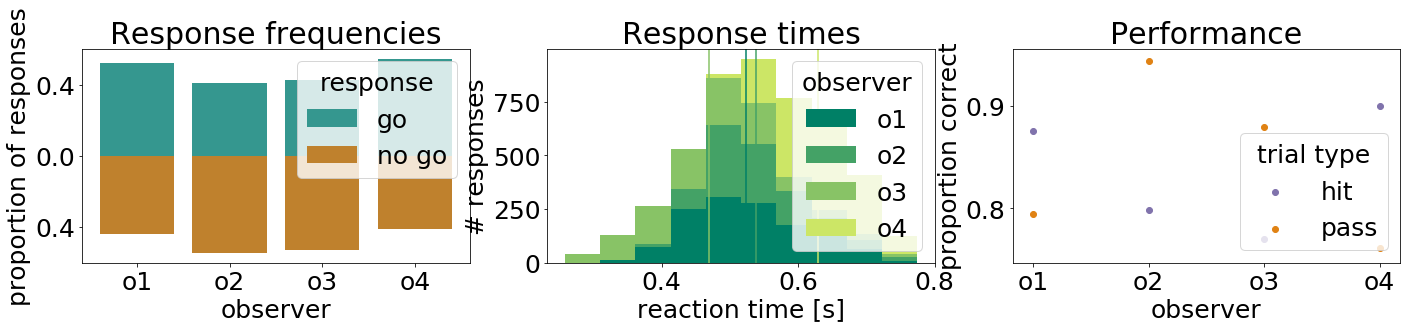

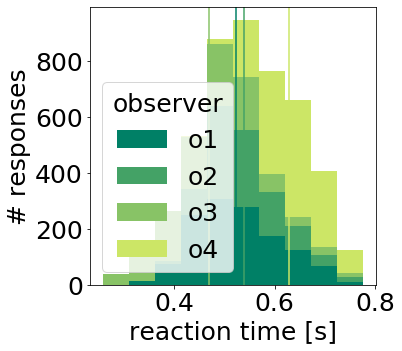

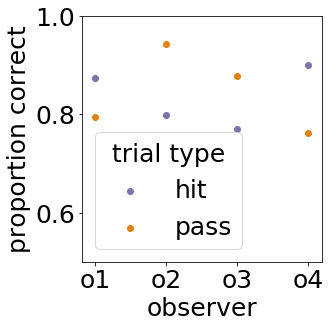

In [9]:
# initialize the combined plot
fig_description, axs_description = plt.subplots(1,3, figsize = (width * 3 * 2, height * 1))

# initialize the individual figures
VSS2021_rts, axs_rts = plt.subplots(1,1, figsize = (width * 1.3, height * 1.3))
VSS2021_performance, axs_perf = plt.subplots(1,1, figsize = (width * 1.3, height * 1.3))

# the first panel will be a graph of the number of go vs. no-go responses
axs_description[0].set_title('Response frequencies');

# the second panel will show the distribution of response times
axs_description[1].set_title('Response times');

# the third panel will show the proportion correct trial by condition
axs_description[2].set_title('Performance');

# create a subject vector
# actual subject IDs are AD, AE, AF, AG
subject_vec = ['o1', 'o2', 'o3', 'o4']

## plot panel 1
# group by subject and go Response
summary_a_bSG = df.groupby(['subject', 'goResp']).describe().answer
# retrieve the count information from the summary
go_count = summary_a_bSG.loc[((slice("o1","o4")),[1]), :]['count'].values
# flip one information
nogo_count = -1 * (summary_a_bSG.loc[((slice("o1","o4")),[0]), :]['count'].values)
# plot everything
axs_description[0].bar(subject_vec,go_count, color = g_cm(np.linspace(0.2,0.8,2)[1]), label = 'go')
axs_description[0].bar(subject_vec,nogo_count, color = g_cm(np.linspace(0.2,0.8,2)[0]), label = 'no go')

# Use absolute value for y-ticks
ticks =  axs_description[0].get_yticks()
axs_description[0].set_yticklabels([np.round(int(abs(tick))/(3*800), 1) for tick in ticks]);
# add labels
axs_description[0].set_ylabel('proportion of responses')
axs_description[0].set_xlabel('observer')
axs_description[0].legend(title = 'response', loc = 'upper right')

## plot panel 2
# collect reaction times in a list of lists
rts = [df[df.subject == s].rea_time.values for s in np.unique(df.subject)]
axs_description[1].hist(rts, stacked = True, color = s_cm, label = subject_vec)
# one individual figure for the poster
axs_rts.hist(rts, stacked = True, color = s_cm, label = subject_vec)

for s,c in zip(np.unique(df.subject), s_cm):
    axs_description[1].axvline(x = np.mean(df[df.subject == s].rea_time), color = c)
    axs_rts.axvline(x = np.mean(df[df.subject == s].rea_time), color = c)
    
axs_description[1].legend(title= 'observer', loc = 'upper right')

axs_description[1].set_xlabel('reaction time [s]')
axs_description[1].set_ylabel('# responses')

axs_rts.legend(title = 'observer', loc = 'lower left')
axs_rts.set_xlabel('reaction time [s]')
axs_rts.set_ylabel('# responses')
 
## plot panel 3
# for every subject and trial type
axs_description[2].scatter(subject_vec,summary_a_bSH.loc[((slice("o1","o4")),[1]), :]['mean'].values, label = 'hit', color = c_cm(np.linspace(0.2,0.8,2))[1])
axs_description[2].scatter(subject_vec,summary_a_bSH.loc[((slice("o1","o4")),[0]), :]['mean'].values, label = 'pass', color = c_cm(np.linspace(0.2,0.8,2))[0])
axs_description[2].set_xlabel('observer')
axs_description[2].set_ylabel('proportion correct')
axs_description[2].legend(title = 'trial type', loc = 'lower right');

# individual plot for poster
axs_perf.scatter(subject_vec,summary_a_bSH.loc[((slice("o1","o4")),[1]), :]['mean'].values, label = 'hit', color = c_cm(np.linspace(0.2,0.8,2))[1])
axs_perf.scatter(subject_vec,summary_a_bSH.loc[((slice("o1","o4")),[0]), :]['mean'].values, label = 'pass', color = c_cm(np.linspace(0.2,0.8,2))[0])
axs_perf.set_xlabel('observer')
axs_perf.set_ylabel('proportion correct')
axs_perf.legend(title = 'trial type', loc = 'lower left')
axs_perf.set_ylim([0.5, 1])


# save the individual figures (for better controllable formatting)

VSS2021_rts.savefig(path_figs + 'ResponseTimes.pdf', bbox_inches = 'tight')
VSS2021_performance.savefig(path_figs + 'Performance.pdf', bbox_inches = 'tight')


# tight layout for the full figure
plt.tight_layout();

# save the full figure to png and pdf (for better overview)
fig_description.savefig(path_figs+"Description.pdf", bbox_inches='tight')
fig_description.savefig(path_figs+"Description.png", bbox_inches='tight')

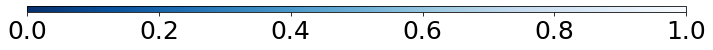

In [10]:
cbar_fig, cbar_ax = plt.subplots(figsize=(3*width, 0.1))
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=t_cm_cont, orientation='horizontal')

cbar_fig.show()
cbar_fig.savefig(path_figs + 'timescale.pdf', bbox_inches = 'tight')

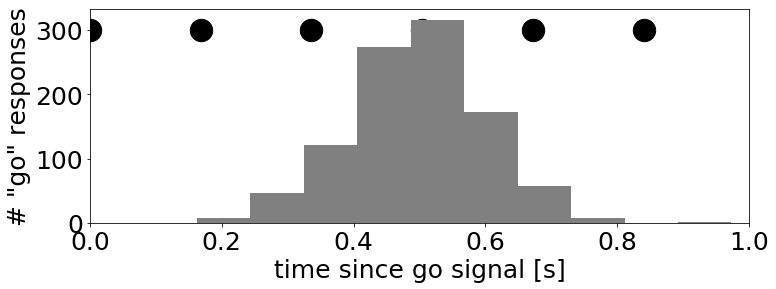

In [11]:
# make a timeline from 0 up to 1 second with response times for go responses, a uniform distribution
# for no-go responses and markers for all samples.

VVSS2021_timecourse, axs_timecourse = plt.subplots(1,1, figsize = (3*width, height))

rts = np.random.normal(loc = 0.5, scale = 0.1, size = 1000)
axs_timecourse.hist(rts, color = 'grey')

# no-go responses
#nogos = [len(df[(df.subject == s) & (df.goResp == 0)].index) for s in np.unique(df.subject)]

#for ng in nogos:
    
#    axs_timecourse.hlines(y = ng/10, xmin = 0.2, xmax = 0.8)


axs_timecourse.scatter(np.linspace(0, 0.84, 6),[300]*6, color = 'black', s = 500)


axs_timecourse.set_xlim(0,1)
#axs_timecourse.legend(loc = 'lower right', title = 'Observer')
axs_timecourse.set_ylabel('# "go" responses')
axs_timecourse.set_xlabel('time since go signal [s]')

VVSS2021_timecourse.savefig(path_figs+'timecourse.pdf', bbox_inches = 'tight');

2. Strategies to solve the task
The task is not trivial to solve and some trials might by chance look like they'd belong to a different catergory then they actually do belong to. In this section, we want to find out, what the optimal response can be.

We will focus on four different response strategies:
1. responses that are based on the vertical distance between the attacker and the sampled.
    a. the above responses are evaluated on a sample-by-sample basis.
    b. the above responses are memorized across samples.
2. responses are based on probability, combining distance with the knowledge about the goal width and the distribution.
    a. the above responses are evaluated on a sample-by-sample basis.
    b. the above responses are memorized across samples.
    
There is an important limitation to the time subjects have to make a decision: 
They need to generate the response while the stimuli are still appearing. 
Therefore, giving the ideal observer here the chance to "look at" all 6 stimuli that appear might be unfair.

To prevent artificially high performance from the ideal observer, we set a "timeout" limit, that takes the response time of our human observers to define how many stimuli the ideal observer is allowed to see.
This still gives the ideal observer an advantage, because the human response time will also include a "dead time" before the hand response has started. 

In [12]:
# The vertical distance of samples is expressed in columns with the name "posSet"
#two samples (first and last) are shown as example
df.groupby('subject').describe()[['samplePosDegAtt_01','samplePosDegAtt_06']]

samplePosDegAtt_01                                                    \
                     count      mean       std       min       25%       50%   
subject                                                                        
o1                  2399.0 -0.018982  4.997320 -9.934574 -4.051923 -0.049529   
o2                  2392.0 -0.030839  4.939706 -9.983106 -4.007512  0.000074   
o3                  2398.0  0.050962  5.017421 -9.913989 -4.035543  0.149964   
o4                  2400.0  0.051712  4.966114 -9.953835 -3.821249 -0.079095   

                            samplePosDegAtt_06                                \
              75%       max              count      mean       std       min   
subject                                                                        
o1       3.980068  9.845756             2399.0  0.028327  5.014484 -9.974722   
o2       3.899816  9.890439             2392.0 -0.015533  5.039636 -9.952221   
o3       4.055732  9.907919             2398.0 -0.036850  4.949934 -9.850285   
o4       4.049289  9.928364             2400.0  0.008175  5.053248 -9.946518   

                                                 
              25%       50%       75%       max  
subject                                          
o1      -4.067957  0.154160  4.096854  9.902038  
o2      -4.061453  0.077694  4.113754  9.936576  
o3      -4.046174  0.070519  3.836085  9.979310  
o4      -4.053050 -0.129664  4.115965  9.894089

Both samples take positions between -10 and +10 degree from the attacker and have a comparable standart deviation.

In [13]:
# The probability of a "hit" is expressed in columns with the name "pi_single_pos"
#two samples (first and last) are shown as example
df.groupby('subject').describe()[['sampleProbHit_01','sampleProbHit_06']]

sampleProbHit_01                                               \
                   count      mean       std  min       25%       50%   
subject                                                                 
o1                2399.0  0.482805  0.306925  0.0  0.244522  0.496101   
o2                2392.0  0.493249  0.308169  0.0  0.257084  0.506310   
o3                2398.0  0.483556  0.308109  0.0  0.254383  0.494167   
o4                2400.0  0.488078  0.305523  0.0  0.252755  0.508098   

                            sampleProbHit_06                           \
              75%       max            count      mean       std  min   
subject                                                                 
o1       0.742225  0.998939           2399.0  0.483275  0.309222  0.0   
o2       0.755530  0.999712           2392.0  0.480692  0.309209  0.0   
o3       0.750669  0.999840           2398.0  0.490246  0.306218  0.0   
o4       0.747924  0.999849           2400.0  0.482502  0.311939  0.0   

                                                 
              25%       50%       75%       max  
subject                                          
o1       0.247897  0.490644  0.751681  0.999818  
o2       0.244361  0.489345  0.743908  0.999977  
o3       0.258221  0.505047  0.750668  0.999666  
o4       0.244506  0.488390  0.757315  0.999254

Both samples have a probability that ranges between 0 and 1, with the same mean, and the same standart deviation at every time point

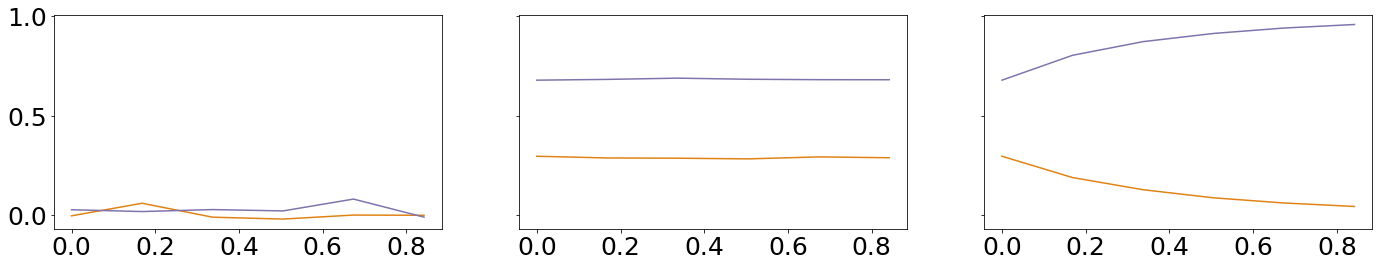

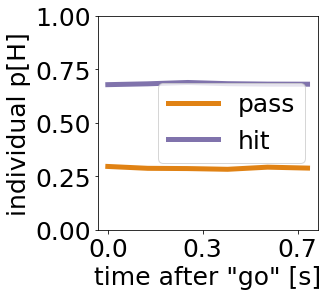

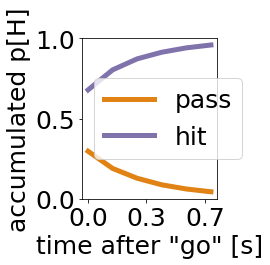

In [14]:
# The values position and probability are drawn from a uniform distribution and should not change over time.
# accumulated probability, however is expected to change over time. We will visualize these changes here

## Figure upper right on poster

# initialize shared figure

fig_dev, axs_dev = plt.subplots(1,3, figsize = (width * 3 * 2 , height), sharex = True, sharey = True)

# initialize individual figures
VSS2021_indProb, axs_indProb = plt.subplots(1,1, figsize = (width, height))
VSS2021_accProb, axs_accProb = plt.subplots(1,1, figsize = (width, height))

# time axis
windows = np.linspace(min(long_df.sampleTimeMsGo)/1000, max(long_df.sampleTimeMsGo)/1000, 6)

# axis for probability
probs = np.linspace(0,1,5)

# group the probability by tw
long_df_acc = df.melt(id_vars=['hitGoal'], value_vars=['sampleAccprobHit_01','sampleAccprobHit_02','sampleAccprobHit_03','sampleAccprobHit_04','sampleAccprobHit_05','sampleAccprobHit_06'], var_name='sampleID', value_name='sampleAccprobHit')
long_df_ind = df.melt(id_vars=['hitGoal'], value_vars=['sampleProbHit_01','sampleProbHit_02','sampleProbHit_03','sampleProbHit_04','sampleProbHit_05','sampleProbHit_06'], var_name='sampleID', value_name='sampleProbHit')
long_df_pos = df.melt(id_vars=['hitGoal'], value_vars=['samplePosDegCen_01','samplePosDegCen_02','samplePosDegCen_03','samplePosDegCen_04','samplePosDegCen_05','samplePosDegCen_06'], var_name='sampleID', value_name='samplePosDegCen')

grouped_ind = long_df_ind.groupby(['sampleID','hitGoal']).describe()['sampleProbHit']
grouped_acc = long_df_acc.groupby(['sampleID','hitGoal']).describe()['sampleAccprobHit']
grouped_pos = long_df_pos.groupby(['sampleID','hitGoal']).describe()['samplePosDegCen']

# plot the mean developments for both conditions

axs_dev[0].plot(windows,grouped_pos.loc[((slice("samplePosDegCen_01","samplePosDegCen_06")),[0]), :]['mean'].values, label = 'pass', color = c_cm(np.linspace(0.2,0.8,2))[0])
axs_dev[0].plot(windows,grouped_pos.loc[((slice("samplePosDegCen_01","samplePosDegCen_06")),[1]), :]['mean'].values, label = 'hit', color = c_cm(np.linspace(0.2,0.8,2))[1])

axs_dev[1].plot(windows,grouped_ind.loc[((slice("sampleProbHit_01","sampleProbHit_06")),[0]), :]['mean'].values, label = 'pass', color = c_cm(np.linspace(0.2,0.8,2))[0])
axs_dev[1].plot(windows,grouped_ind.loc[((slice("sampleProbHit_01","sampleProbHit_06")),[1]), :]['mean'].values, label = 'hit', color = c_cm(np.linspace(0.2,0.8,2))[1])

axs_dev[2].plot(windows,grouped_acc.loc[((slice("sampleAccprobHit_01","sampleAccprobHit_06")),[0]), :]['mean'].values, label = 'pass', color = c_cm(np.linspace(0.2,0.8,2))[0])
axs_dev[2].plot(windows,grouped_acc.loc[((slice("sampleAccprobHit_01","sampleAccprobHit_06")),[1]), :]['mean'].values, label = 'hit', color = c_cm(np.linspace(0.2,0.8,2))[1])

# plot the developments for each plot individually
# set limits
axs_indProb.set_ylim([0,1])
axs_accProb.set_ylim([0,1])

axs_indProb.plot(windows,grouped_ind.loc[((slice("sampleProbHit_01","sampleProbHit_06")),[0]), :]['mean'].values, label = 'pass', color = c_cm(np.linspace(0.2,0.8,2))[0], linewidth = 5)
axs_indProb.plot(windows,grouped_ind.loc[((slice("sampleProbHit_01","sampleProbHit_06")),[1]), :]['mean'].values, label = 'hit', color = c_cm(np.linspace(0.2,0.8,2))[1], linewidth = 5)

axs_accProb.plot(windows,grouped_acc.loc[((slice("sampleAccprobHit_01","sampleAccprobHit_06")),[0]), :]['mean'].values, label = 'pass', color = c_cm(np.linspace(0.2,0.8,2))[0], linewidth = 5)
axs_accProb.plot(windows,grouped_acc.loc[((slice("sampleAccprobHit_01","sampleAccprobHit_06")),[1]), :]['mean'].values, label = 'hit', color = c_cm(np.linspace(0.2,0.8,2))[1], linewidth = 5)

# set ticks and labels
axs_indProb.set_xticks(np.linspace(0,1,6)[::2])
axs_indProb.set_xticklabels(np.round(windows, 1)[::2])

axs_accProb.set_xticks(np.linspace(0,1,6)[::2])
axs_accProb.set_xticklabels(np.round(windows, 1)[::2])

axs_indProb.legend()
axs_indProb.set_xlabel('time after "go" [s]')
axs_indProb.set_ylabel('individual p[H]')

# plot legend
axs_accProb.legend()
axs_accProb.set_xlabel('time after "go" [s]')
axs_accProb.set_ylabel('accumulated p[H]');

# save figures
VSS2021_indProb.savefig(path_figs+"IndividualProbability.pdf", bbox_inches='tight')
VSS2021_accProb.savefig(path_figs+"AccumulatedProbability.pdf", bbox_inches='tight')

plt.tight_layout()

In [15]:
# Analysis for the maximum performance based on position, probability and the accumulated probability value
# the variable "p_on_move" stores which target was shown when the movement started.
# when no movement was made, we will use the full sequence

# for position and probability values, we will use the 

# define name arrays to access later
# the position is expressed relative to the screen center
position_names = ['samplePosDegAtt_01','samplePosDegAtt_02','samplePosDegAtt_03','samplePosDegAtt_04','samplePosDegAtt_05','samplePosDegAtt_06']
probability_names = ['sampleProbHit_01','sampleProbHit_02','sampleProbHit_03','sampleProbHit_04','sampleProbHit_05','sampleProbHit_06']
probabilityacc_names = ['sampleAccprobHit_01','sampleAccprobHit_02','sampleAccprobHit_03','sampleAccprobHit_04','sampleAccprobHit_05','sampleAccprobHit_06']

# get a variable that tells us how many stimuli were shown
df['p_on_move'] = np.floor(df.rea_time/(1/6))

# when there is no reaction time, set the values of p_on_move to -1, so we can use it as index
df.loc[np.where(np.isnan(df.p_on_move))[0],'p_on_move'] = len(probability_names)-1

# initialize an array of strategies
# posmean = decision based on the mean values of all positions seen up to the response
# poslast = decision based on the last position value seen before the response
# probmean = decision based on the mean value of all probabilities seen up to the response
# problast = decision based on the last probability value seen before the response
# probacc = decision based on the probability accumulated up to the response
strategies = ['posmean', 'poslast', 'probmean', 'problast', 'probacc']
strategies.sort()

# create a dataset to collect the new values
df_ideal = []

# compute the means for every line
for s in strategies:
    
    # copy the old dataset
    df_strategy = df.copy()
    
    if (s == 'posmean'):
        decision_value = np.abs([np.mean(df.loc[n,position_names[:int(df.loc[n,'p_on_move'])+1]]) for n in df.index])
    elif (s == 'poslast'):
        decision_value = np.abs([np.mean(df.loc[n,position_names[int(df.loc[n,'p_on_move'])]]) for n in df.index])
    elif (s == 'probmean'):
        decision_value = [np.mean(df.loc[n,probability_names[:int(df.loc[n,'p_on_move'])+1]]) for n in df.index]
    elif (s == 'problast'):
        decision_value = [np.mean(df.loc[n,probability_names[int(df.loc[n,'p_on_move'])]]) for n in df.index]
    elif (s == 'probacc'):
        decision_value = [np.mean(df.loc[n,probabilityacc_names[int(df.loc[n,'p_on_move'])]]) for n in df.index]
    
    df_strategy['decisionValue'] = decision_value
    df_strategy['strategy'] = s
    
    df_ideal.append(df_strategy)


# the values the ideal observer will base their judgement on
df_ideal = pd.concat(df_ideal, axis = 0)


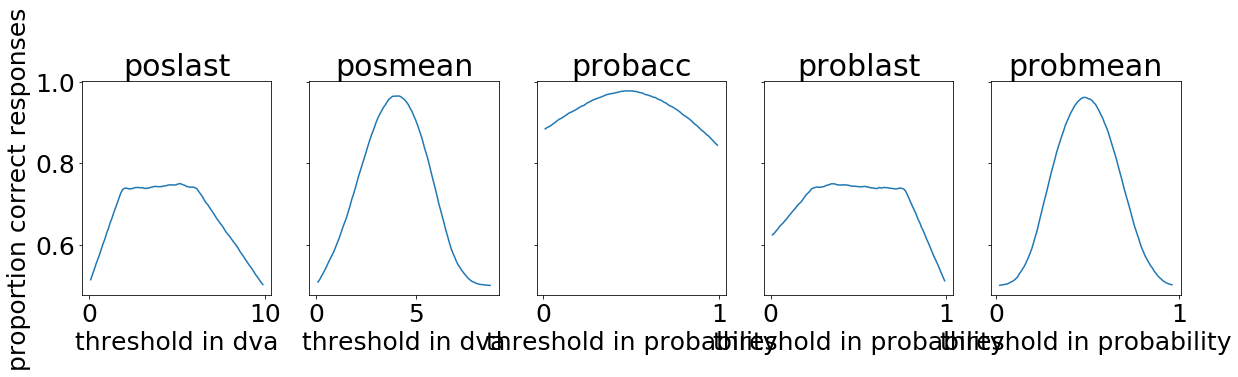

In [16]:
# Next, we can use this values for a decision. We need to compute a threshold 
# at which value to decide if we should go or not

# to find this threshold, we compute performance at different thresholds and take the best value
# initialize an array for the best performing threshold

ideal_thresholds = {}

# initialize a figure
fig_ideal_observer, axs_ideal_observer = plt.subplots(1,5, sharey = True, figsize = (5 * width , height))
    
for idx, s in enumerate(strategies):
    
    # set the thresholds we want to explore
    strategy_thresh = np.linspace(min(df_ideal[df_ideal.strategy == s].decisionValue),max(df_ideal[df_ideal.strategy == s].decisionValue), 100)
    # retrieve the relevant dataframe
    df_str = df_ideal[df_ideal.strategy == s]
    # initialize an empty dictionary for performance
    strategy_performance = []
    
    # test all thresholds
    for thr in strategy_thresh:
        # the direction of comparison depends on the methods: when using position, small values should result in a go response,
        # and with probability, large values result in a go response
        if 'pos' in s:
            strategy_answer = (df_str.decisionValue <= thr).astype('int')
        else:
            strategy_answer = (df_str.decisionValue >= thr).astype('int')
            
        # compute if the answer was correct
        strategy_correct = 1-abs(strategy_answer - df_str.hitGoal)
        # and collect the mean performance
        strategy_performance.append(np.mean(strategy_correct))
    
    # append the ideal threshold:
    ideal_thresholds[s] = strategy_thresh[np.argmax(strategy_performance)]


    axs_ideal_observer[idx].set_title(s)  
    # remove 0 values  before plotting
    strategy_performance[0] = np.nan
    strategy_performance[-1] = np.nan
    axs_ideal_observer[idx].plot(strategy_thresh, strategy_performance)
    

axs_ideal_observer[0].set_ylabel('proportion correct responses')
axs_ideal_observer[0].set_xlabel('threshold in dva')
axs_ideal_observer[1].set_xlabel('threshold in dva')

axs_ideal_observer[2].set_xlabel('threshold in probability')
axs_ideal_observer[3].set_xlabel('threshold in probability')
axs_ideal_observer[4].set_xlabel('threshold in probability');


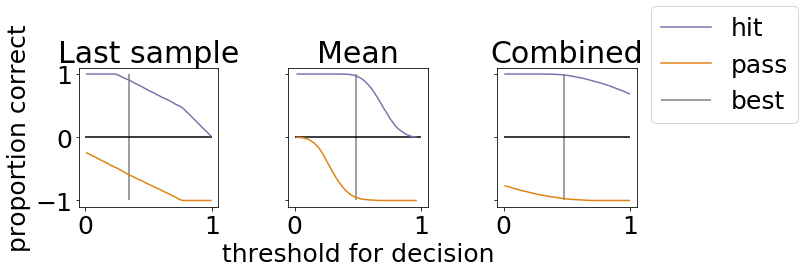

In [17]:
fig_reduced_io, axs_reduced_io = plt.subplots(1, 3, sharex = True, sharey=True, figsize = (width * 3, height * 1))

axs_reduced_io[0].set_title('Last sample')
axs_reduced_io[1].set_title('Mean')
axs_reduced_io[2].set_title('Combined')
#axs_reduced_io[3].set_title('Linear Regression')


for idx, s in enumerate(['problast', 'probmean', 'probacc']):
    
    # set the thresholds we want to explore
    strategy_thresh = np.linspace(min(df_ideal[df_ideal.strategy == s].decisionValue),max(df_ideal[df_ideal.strategy == s].decisionValue), 100)
    # retrieve the relevant dataframe
    df_str = df_ideal[df_ideal.strategy == s]
    # initialize an empty dictionary for performance
    strategy_hit_performance = []
    strategy_nohit_performance = []
    
    # test all thresholds
    for thr in strategy_thresh:
        # the direction of comparison depends on the methods: when using position, small values should result in a go response,
        # and with probability, large values result in a go response
        if 'pos' in s:
            strategy_answer = (df_str.decisionValue <= thr).astype('int')
        else:
            strategy_answer = (df_str.decisionValue >= thr).astype('int')
            
        # compute if the answer was correct
        strategy_correct = 1-abs(strategy_answer - df_str.hitGoal)
        # and collect the mean performance
        strategy_hit_performance.append(np.mean(strategy_correct[df.hitGoal == 1]))
        strategy_nohit_performance.append(-1 * np.mean(strategy_correct[df.hitGoal == 0]))

    axs_reduced_io[idx].plot(strategy_thresh[1:-1], strategy_hit_performance[1:-1], color = c_cm(np.linspace(0.2,0.8,2))[1], label = 'hit')
    axs_reduced_io[idx].plot(strategy_thresh[1:-1], strategy_nohit_performance[1:-1], color = c_cm(np.linspace(0.2,0.8,2))[0], label = 'pass')
    combined = np.subtract(strategy_hit_performance, strategy_nohit_performance)
    axs_reduced_io[idx].vlines(strategy_thresh[np.argmax(combined)], ymin = -1, ymax =1, label = 'best', color = 'grey')
    axs_reduced_io[idx].hlines(0, xmin = 0, xmax =1)

#ticks =  axs_reduced_io[0].get_yticks()
#axs_reduced_io[0].set_yticklabels([abs(tick) for tick in ticks]);
axs_reduced_io[1].set_xlabel('threshold for decision')
axs_reduced_io[0].set_ylabel('proportion correct')

axs_reduced_io[2].legend(loc = (1.1, 0.6))

plt.tight_layout()

fig_reduced_io.savefig(path_figs+"IdealObserverStrategies.pdf", bbox_inches='tight')
fig_reduced_io.savefig(path_figs+"IdealObserverStrategies.png", bbox_inches='tight')

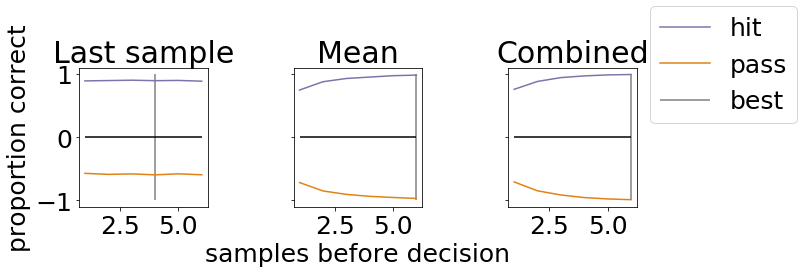

In [18]:
# Performance advanteages in different time windows

fig_timewindow_io, axs_timewindow_io = plt.subplots(1,3, sharex = True, sharey=True, figsize = (width * 3, height * 1))

axs_timewindow_io[0].set_title('Last sample')
axs_timewindow_io[1].set_title('Mean')
axs_timewindow_io[2].set_title('Combined')
# axs_timewindow_io[3].set_title('Linear Regression')


for idx, s in enumerate(['problast', 'probmean', 'probacc']):
    
    df_str = df_ideal[df_ideal.strategy == s]
    # get a list of the time windows we want to explore
    time_window = range(1,7)
    
    # initialize an empty dictionary for performance
    strategy_hit_performance_tw = []
    strategy_nohit_performance_tw = []
    
    # test all thresholds
    for tw in time_window:
        # get the decision values for this time window
        if s == 'problast':
            decisionValue = df_str['sampleProbHit_0{}'.format(tw)]
        elif s == 'probmean':
            try:
                decisionValue = np.mean(df_str.loc[:,['sampleProbHit_0{}'.format(x) for x in range(1,tw + 1)]], axis = 1)
            except:
                continue
        elif s == 'probacc':
            decisionValue = df_str['sampleAccprobHit_0{}'.format(tw)]
              
        strategy_answer = (decisionValue >= ideal_thresholds[s]).astype('int')

        # compute if the answer was correct
        strategy_correct = 1-abs(strategy_answer - df_str.hitGoal)

        # and collect the mean performance
        strategy_hit_performance_tw.append(np.mean(strategy_correct[df.hitGoal == 1]))
        strategy_nohit_performance_tw.append(-1 * np.mean(strategy_correct[df.hitGoal == 0]))


    axs_timewindow_io[idx].plot(range(1,7), strategy_hit_performance_tw, color = c_cm(np.linspace(0.2,0.8,2))[1], label = 'hit')
    axs_timewindow_io[idx].plot(range(1,7), strategy_nohit_performance_tw, color = c_cm(np.linspace(0.2,0.8,2))[0], label = 'pass')
    combined = np.subtract(strategy_hit_performance_tw, strategy_nohit_performance_tw)
    axs_timewindow_io[idx].vlines(np.argmax(combined)+1, ymin = -1, ymax =1, label = 'best', color = 'grey')
    axs_timewindow_io[idx].hlines(0, xmin = 1, xmax =6)

#ticks =  axs_timewindow_io[0].get_yticks()
#axs_timewindow_io[0].set_yticklabels([abs(tick) for tick in ticks]);
axs_timewindow_io[1].set_xlabel('samples before decision')
axs_timewindow_io[0].set_ylabel('proportion correct')
axs_timewindow_io[2].legend(loc = (1.1, 0.6))

plt.tight_layout()

fig_timewindow_io.savefig(path_figs+"IdealObserverTimes.pdf", bbox_inches='tight')
fig_timewindow_io.savefig(path_figs+"IdealObserverTimes.png", bbox_inches='tight')

The best threshold lies around 4 when comparing positions, and around 0.5 when using probabilities. The highest possible performance does not differ between position-based decisions and probability based decisions, when the mean-strategy is used for both. The best possible performance is reached with accumulated probability.

In [19]:
# # get the responses with that ideal threshold for all trials run during the experiment
# # the next two cells are redundant to the cell above, with the only difference that they also include the position based strategies

# # append columns for ideal observer answers and correct/incorrect
# df_ideal['ioAnswer'] = np.nan
# df_ideal['ioCorrect'] = np.nan

# for s in strategies: 
#     if 'pos' in s:
#         df_ideal.loc[df_ideal.strategy == s, 'ioAnswer'] = (df_ideal[df_ideal.strategy == s].decisionValue <= ideal_thresholds[s]).astype('int')
#     else:
#         df_ideal.loc[df_ideal.strategy == s, 'ioAnswer'] = (df_ideal[df_ideal.strategy == s].decisionValue >= ideal_thresholds[s]).astype('int')

#     # compute if the answer was correct
#     df_ideal.loc[df_ideal.strategy == s, 'ioCorrect'] = 1-abs(df_ideal.loc[df_ideal.strategy == s, 'ioAnswer'] - df_ideal[df_ideal.strategy == s].hitGoal)

In [20]:
##  
# fig_idealobserver, axs_idealobserver = plt.subplots(1,2, figsize = (12,5))

# # the first panel will be a graph of the number of go vs. no-go responses
# axs_idealobserver[0].set_title('Number of Go vs. NoGo Responses');

# # the third panel will show the proportion correct trial by condition
# axs_idealobserver[1].set_title('Performance by condition');

# # # recreate the real observer plots for our ideal observers
# # ## plot panel 1
# # # group by observer strategy and go Response
# summary_a_bIG = df_ideal.groupby(['strategy', 'ioAnswer']).describe().ioCorrect
# # # retrieve the count information from the summary
# go_count = summary_a_bIG.loc[((slice("poslast","probmean")),[1]), :]['count'].values
# # # flip one information
# nogo_count = -1 * (summary_a_bIG.loc[((slice("poslast","probmean")),[0]), :]['count'].values)
# # # plot everything
# axs_idealobserver[0].bar(strategies,go_count, color = g_cm(np.linspace(0.2,0.8,2)[1]), label = 'go')
# axs_idealobserver[0].bar(strategies,nogo_count, color = g_cm(np.linspace(0.2,0.8,2)[0]), label = 'nogo')
# # # Use absolute value for y-ticks
# ticks =  axs_idealobserver[0].get_yticks()
# axs_idealobserver[0].set_yticklabels([np.round(int(abs(tick))/(4*3*800), 1) for tick in ticks]);


# axs_idealobserver[1].scatter(strategies,summary_a_bIG.loc[((slice("poslast","probmean")),[0]), :]['mean'].values, label = 'pass')
# axs_idealobserver[1].scatter(strategies,summary_a_bIG.loc[((slice("poslast","probmean")),[1]), :]['mean'].values, label = 'hit')
# axs_idealobserver[1].legend();

# # optional: time course how the probabilities develop

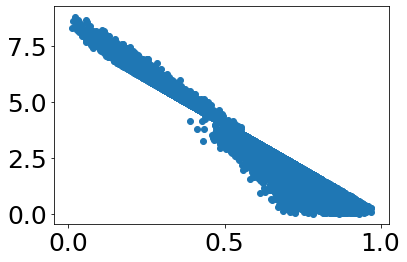

In [21]:
# It seems that the mean strategies using probability and using position result in highly comparable responses. 
# Let's check their correlation

plt.scatter(df_ideal[df_ideal.strategy == 'probmean'].decisionValue, df_ideal[df_ideal.strategy == 'posmean'].decisionValue)

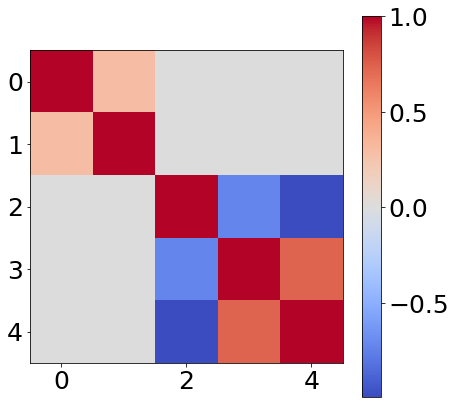

In [22]:
# to be sure, we can check the correlation between the non-averaged values

corr_columns = ['samplePosDegCen', 'samplePosDegAtt', 'absSamplePosDegAtt', 'sampleAccprobHit','sampleProbHit']
corr_plot, corr_axis = plt.subplots(1,1, figsize = (7,7))
f = corr_axis.imshow(long_df.loc[:,corr_columns].corr('pearson'), cmap = plt.get_cmap('coolwarm'))
plt.colorbar(f);
#corr_axis.set_xticklabels(corr_columns, rotation = 90)
#corr_axis.set_yticklabels(corr_columns, rotation = 0);

In [23]:
# The best performance is achieved by an observer who bases their response on the last observed accumulated probability.
# in order to check, if this model would also do a good job in describing human behaviour, we need to include that variable 
# into our data set.

df['lastAccprobHit'] = df_ideal[df_ideal.strategy == 'probacc'].decisionValue.values

2 a linear/logistic modelling of behavioural data

As seen in the plot above, the measures distance and probability are highly correlated. It makes no sense to test both of them in a model. I will pick probabbility as the reported measure here, but please, bear in mind that subjects could easily monitor distance, as well, and achieve the same behavioural results. The reason I pick probability over position is that for probability, I have developed way of computing the probability as an accumulated measure, taking into account the goal size. This is so far missing for position.

So the three models that will be compared against each other will be:

1. responses ~ time * accumulatedProbabiliy + (1+time+accumulatedProbability|Subject) - for this model, I will use the full time course of accumulated probabilities
2. responses ~ time * accumulatedProbability(last) + (1 + accumulatedProbability(last)|subject) - this model is based on the last observed variable and fitted with the short data frame
3. responses ~ time * individualProbability + (1+time+individualProbability|Subject)

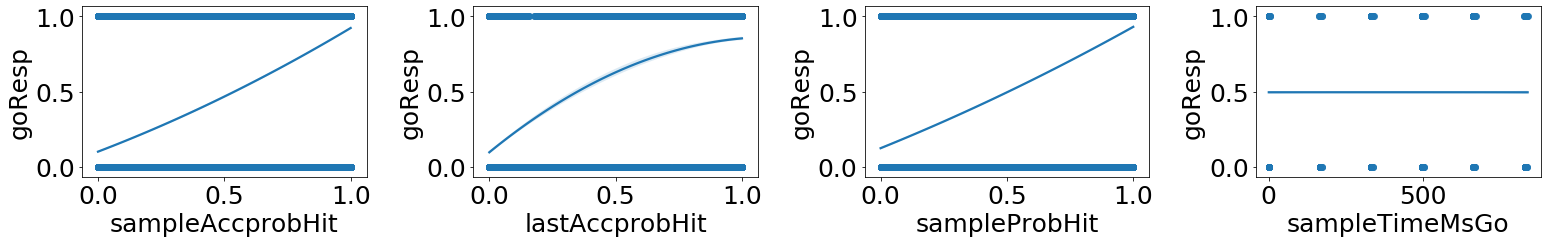

In [24]:
# the dependent variables
y_goresp = long_df['goResp'] # response go/nogo

# the independent variables will be probability and time relative to the the go signal
x_probacc = long_df['sampleAccprobHit']
x_probacclast = df['lastAccprobHit']
x_probind = long_df['sampleProbHit']
x_timego = long_df['sampleTimeMsGo']

# make a plot for our overview
fig_overview_resp, axs_overview_resp = plt.subplots(1,4, figsize = (4 * width + 4 * gaps, height))

sb.regplot(x_probacc, y_goresp, order = 2, ax = axs_overview_resp[0])
sb.regplot(x_probacclast, df.goResp, order = 2, ax = axs_overview_resp[1])
sb.regplot(x_probind, y_goresp, order = 2, ax = axs_overview_resp[2])
sb.regplot(x_timego, y_goresp, order = 2, ax = axs_overview_resp[3])

plt.tight_layout()

### We can see here that the values are not centered and have very different values. So we want to rescale them.

In [25]:
### rescale variables
# from all variables: substract the mean and divide by standart deviation

def normalize(data):
    
    sd = np.std(data)
    mean = np.mean(data)
    
    normal_data = (data - mean)/sd
    
    return normal_data

## these are a data frames that will hold normalized data
normal_long_df = long_df.copy()
normal_df = df.copy()

normal_long_df.loc[:,'sampleAccprobHit'] = normalize(normal_long_df.loc[:,'sampleAccprobHit'].values)
normal_long_df.loc[:,'sampleProbHit'] = normalize(normal_long_df.loc[:,'sampleProbHit'].values)
normal_long_df.loc[:,'sampleTimeMsGo'] = normalize(normal_long_df.loc[:,'sampleTimeMsGo'].values)

normal_df.loc[:,'lastAccprobHit'] = normalize(normal_df.loc[:,'lastAccprobHit'].values)

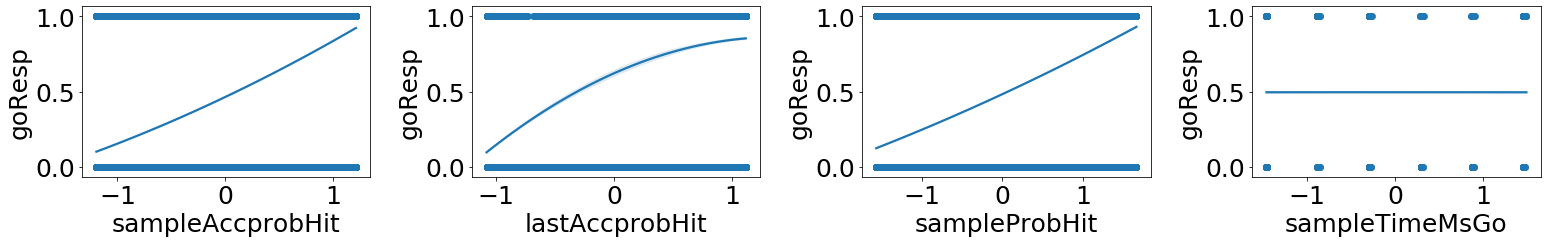

In [26]:
## plot the normalized values
fig_normalized_resp, axs_normalized_resp = plt.subplots(1,4, figsize = (4 * width + 4 * gaps, height))

sb.regplot(normal_long_df.sampleAccprobHit, normal_long_df.goResp, order = 2, ax = axs_normalized_resp[0])
sb.regplot(normal_df.lastAccprobHit, normal_df.goResp, order = 2, ax = axs_normalized_resp[1])
sb.regplot(normal_long_df.sampleProbHit, normal_long_df.goResp, order = 2, ax = axs_normalized_resp[2])
sb.regplot(normal_long_df.sampleTimeMsGo, normal_long_df.goResp, order = 2, ax = axs_normalized_resp[3])

plt.tight_layout()

In [27]:
# fit two full models, one for the accumulated probability, one for the individual probability
# full accumulated
resp_mfull_accumulated = Lmer('goResp ~ sampleAccprobHit * sampleTimeMsGo + (1 + sampleAccprobHit + sampleTimeMsGo|subject)', data = normal_long_df, family = 'binomial')

# full accumulated last value
resp_mfull_accumulated_last = Lmer('goResp ~  lastAccprobHit +(1 + lastAccprobHit|subject)', data = normal_df, family = 'binomial')

# full individual
resp_mfull_individual = Lmer('goResp ~ sampleProbHit * sampleTimeMsGo + (1 + sampleProbHit + sampleTimeMsGo|subject)', data = normal_long_df, family = 'binomial')

In [28]:
## fit all full models
if not resp_mfull_accumulated.fitted:
    resp_mfull_accumulated.fit()
if not resp_mfull_accumulated_last.fitted:
    resp_mfull_accumulated_last.fit()
if not resp_mfull_individual.fitted:
    resp_mfull_individual.fit()

boundary (singular) fit: see ?isSingular 

Formula: goResp~sampleAccprobHit*sampleTimeMsGo+(1+sampleAccprobHit+sampleTimeMsGo|subject)

Family: binomial	 Inference: parametric

Number of observations: 57534	 Groups: {'subject': 4.0}

Log-likelihood: -23435.930 	 AIC: 46891.860

Random effects:

                     Name    Var    Std
subject       (Intercept)  0.259  0.509
subject  sampleAccprobHit  0.037  0.192
subject    sampleTimeMsGo  0.001  0.023

                      IV1               IV2   Corr
subject       (Intercept)  sampleAccprobHit -0.779
subject       (Intercept)    sampleTimeMsGo  0.989
subject  sampleAccprobHit    sampleTimeMsGo -0.864

Fixed effects:

Formula: goResp~lastAccprobHit+(1+lastAccprobHit|subject)

Family: binomial	 Inference: parametric

Number of observations: 9589	 Groups: {'subject': 4.0}

Log-likelihood: -3928.155 	 AIC: 7866.310

Random effects:

                   Name    Var    Std
subject     (Intercept)  0.237  0.487
subject  lastAccprobHit  0.018

In [29]:
# resp_mfull_accumulated produced a singluar fit and took a very long time to merge.
# the "time" random effect has 0 variance, and seems to be irrelevant. 
# Therefore, we leave it out

resp_m2_accumulated = Lmer('goResp ~ sampleAccprobHit * sampleTimeMsGo + (1 + sampleAccprobHit|subject)', data = normal_long_df, family = 'binomial')
resp_m2_accumulated.fit()

# the same was true for the other long format model
resp_m2_individual = Lmer('goResp ~ sampleProbHit * sampleTimeMsGo + (1 + sampleProbHit|subject)', data = normal_long_df, family = 'binomial')
resp_m2_individual.fit()


Formula: goResp~sampleAccprobHit*sampleTimeMsGo+(1+sampleAccprobHit|subject)

Family: binomial	 Inference: parametric

Number of observations: 57534	 Groups: {'subject': 4.0}

Log-likelihood: -23437.705 	 AIC: 46889.411

Random effects:

                     Name    Var    Std
subject       (Intercept)  0.257  0.507
subject  sampleAccprobHit  0.036  0.190

                 IV1               IV2  Corr
subject  (Intercept)  sampleAccprobHit -0.78

Fixed effects:

Formula: goResp~sampleProbHit*sampleTimeMsGo+(1+sampleProbHit|subject)

Family: binomial	 Inference: parametric

Number of observations: 57534	 Groups: {'subject': 4.0}

Log-likelihood: -31462.107 	 AIC: 62938.215

Random effects:

                  Name    Var    Std
subject    (Intercept)  0.112  0.334
subject  sampleProbHit  0.005  0.072

                 IV1            IV2   Corr
subject  (Intercept)  sampleProbHit -0.791

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.049,-0.378,0.279,0.168,0.952,0.685,1.322,0.488,0.407,0.569,-0.294,0.768,
sampleProbHit,1.235,1.161,1.310,0.038,3.440,3.193,3.706,0.775,0.762,0.787,32.550,0.000,***
sampleTimeMsGo,0.013,-0.007,0.032,0.010,1.013,0.993,1.032,0.503,0.498,0.508,1.286,0.198,
sampleProbHit:sampleTimeMsGo,-0.224,-0.246,-0.202,0.011,0.799,0.782,0.817,0.444,0.439,0.450,-19.850,0.000,***


In [30]:
# The model converges, but the variance explained by inclding a random term for the decision value slopes is very small.
# Therefore, we reduce these models even further to include only the intercept
# reduce both long format models

resp_m3_accumulated = Lmer('goResp ~ sampleAccprobHit * sampleTimeMsGo + (1|subject)', data = normal_long_df, family = 'binomial')
resp_m3_accumulated.fit()

resp_m3_individual = Lmer('goResp ~ sampleProbHit * sampleTimeMsGo + (1|subject)', data = normal_long_df, family = 'binomial')
resp_m3_individual.fit()

# reduce the short format model to contain only the intercept, too
resp_m3_accumulated_last = Lmer('goResp ~  lastAccprobHit + (1|subject)', data = normal_df, family = 'binomial')
resp_m3_accumulated_last.fit()


Formula: goResp~sampleAccprobHit*sampleTimeMsGo+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 57534	 Groups: {'subject': 4.0}

Log-likelihood: -23511.357 	 AIC: 47032.714

Random effects:

                Name    Var    Std
subject  (Intercept)  0.236  0.486

No random effect correlations specified

Fixed effects:

Formula: goResp~sampleProbHit*sampleTimeMsGo+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 57534	 Groups: {'subject': 4.0}

Log-likelihood: -31478.503 	 AIC: 62967.006

Random effects:

                Name    Var    Std
subject  (Intercept)  0.109  0.331

No random effect correlations specified

Fixed effects:

Formula: goResp~lastAccprobHit+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 9589	 Groups: {'subject': 4.0}

Log-likelihood: -3933.177 	 AIC: 7872.353

Random effects:

                Name    Var    Std
subject  (Intercept)  0.227  0.476

No random effect correlations spe

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.033,-0.503,0.437,0.240,0.968,0.605,1.548,0.492,0.377,0.608,-0.138,0.891,
lastAccprobHit,1.862,1.799,1.926,0.032,6.439,6.045,6.860,0.866,0.858,0.873,57.700,0.000,***


In [31]:
# compare the model outcomes

#we have fitted 7 models
#three full models
#resp_mfull_accumulated.coefs
#resp_mfull_accumulated_last.coefs
#resp_mfull_individual.coefs

#two reduced models with only one random main effect
#resp_m2_accumulated.coefs
#resp_m2_individual.coefs

# three reduced models with only a random intercept
#resp_m3_accumulated.coefs
#resp_m3_individual.coefs
#resp_m3_accumulated_last.coefs

# In order to have clean overview of the model results, we will put them all in one table

models = [resp_mfull_accumulated,resp_mfull_accumulated_last,resp_mfull_individual,
          resp_m2_accumulated,resp_m2_individual, resp_m3_accumulated, 
          resp_m3_accumulated_last,resp_m3_individual]

model_columns = ['model', 'Intercept', 'sampleProbability', 'sampleTime', 'probabilityTime', 'AIC', 'logLik']

model_df = pd.DataFrame(index = np.arange(0,len(models)), columns = model_columns)

for m_id,m in enumerate(models):
    
    model_df.model[m_id] = m.formula
    model_df.AIC[m_id] = m.AIC
    model_df.logLik[m_id] = m.logLike
    
    for i in m.coefs.index:
        if 'Intercept' in i:
            model_df.Intercept[m_id] = m.coefs.loc[i, 'Estimate']
        elif 'prob' in i or 'Prob' in i:
            if ':' in i:
                model_df.probabilityTime[m_id] = m.coefs.loc[i, 'Estimate']
            else:
                model_df.sampleProbability[m_id] = m.coefs.loc[i, 'Estimate']
        else:     
            model_df.sampleTime[m_id] = m.coefs.loc[i, 'Estimate']
        
    
    #model_df.BIC[m_id] = m.BIC

In [32]:
model_df

,model,Intercept,sampleProbability,sampleTime,probabilityTime,AIC,logLik
0,goResp~sampleAccprobHit*sampleTimeMsGo+(1+samp...,-0.077912,2.01276,-0.0235516,-0.290128,46891.9,-23435.9
1,goResp~lastAccprobHit+(1+lastAccprobHit|subject),-0.0522283,1.87081,NaN,NaN,7866.31,-3928.16
2,goResp~sampleProbHit*sampleTimeMsGo+(1+sampleP...,-0.0495295,1.23675,0.0133873,-0.229069,62935.4,-31457.7
3,goResp~sampleAccprobHit*sampleTimeMsGo+(1+samp...,-0.0767758,2.01265,-0.0216411,-0.297702,46889.4,-23437.7
4,goResp~sampleProbHit*sampleTimeMsGo+(1+sampleP...,-0.0493672,1.23545,0.0125591,-0.224057,62938.2,-31462.1
5,goResp~sampleAccprobHit*sampleTimeMsGo+(1|subj...,-0.0395699,1.99413,-0.0117216,-0.297244,47032.7,-23511.4
6,goResp~lastAccprobHit+(1|subject),-0.0329987,1.86244,NaN,NaN,7872.35,-3933.18
7,goResp~sampleProbHit*sampleTimeMsGo+(1|subject),-0.04209,1.23216,0.0122175,-0.223836,62967,-31478.5


In [33]:
# it is hard to compare the model created on the short data frame (model m3_accumulated_last) to 
# the model fitted on the long data frame (model m3_accumulated), because the two models are used to fit a differnt number of parameters.
# both models, that were fitted on the long data frame, however, suggest that there is a significant interaction with time.
# We loose that time interaction, by looking only at the last value.

# We could additionally compute a wide model, to show that there is more than one time window that predicts the responses.

resp_m4_accumulated = Lmer('goResp ~ sampleAccprobHit + sampleAccprobHit:sampleTimeMsGo + (1+sampleAccprobHit|subject)', data = normal_long_df, family = 'binomial')
resp_m4_accumulated.fit()

resp_m4_individual = Lmer('goResp ~ sampleProbHit + sampleProbHit:sampleTimeMsGo + (1+sampleProbHit|subject)', data = normal_long_df, family = 'binomial')
resp_m4_individual.fit()

Formula: goResp~sampleAccprobHit+sampleAccprobHit:sampleTimeMsGo+(1+sampleAccprobHit|subject)

Family: binomial	 Inference: parametric

Number of observations: 57534	 Groups: {'subject': 4.0}

Log-likelihood: -23439.497 	 AIC: 46890.994

Random effects:

                     Name    Var    Std
subject       (Intercept)  0.256  0.506
subject  sampleAccprobHit  0.035  0.188

                 IV1               IV2   Corr
subject  (Intercept)  sampleAccprobHit -0.774

Fixed effects:

Formula: goResp~sampleProbHit+sampleProbHit:sampleTimeMsGo+(1+sampleProbHit|subject)

Family: binomial	 Inference: parametric

Number of observations: 57534	 Groups: {'subject': 4.0}

Log-likelihood: -31462.935 	 AIC: 62937.870

Random effects:

                  Name    Var    Std
subject    (Intercept)  0.112  0.334
subject  sampleProbHit  0.005  0.072

                 IV1            IV2   Corr
subject  (Intercept)  sampleProbHit -0.791

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.048,-0.376,0.280,0.167,0.953,0.686,1.323,0.488,0.407,0.569,-0.289,0.773,
sampleProbHit,1.235,1.161,1.309,0.038,3.439,3.193,3.704,0.775,0.762,0.787,32.611,0.000,***
sampleProbHit:sampleTimeMsGo,-0.223,-0.245,-0.201,0.011,0.800,0.782,0.818,0.444,0.439,0.450,-19.814,0.000,***


In [34]:
# compute the predicted responses from each model
# the .predict() method from pymer only allows us to compute values from parameters in the dataframe.
# so we compute the interaction
normal_long_df['sampleAccprobHit:sampleTimeMsGo'] = normal_long_df.sampleAccprobHit * normal_long_df.sampleTimeMsGo
normal_long_df['sampleProbHit:sampleTimeMsGo'] = normal_long_df.sampleProbHit * normal_long_df.sampleTimeMsGo
m4_accumulated_ypred = resp_m4_accumulated.predict(normal_long_df)
m4_individual_ypred = resp_m4_individual.predict(normal_long_df)
m1_accumulatedlast_ypred = resp_mfull_accumulated_last.predict(normal_df)

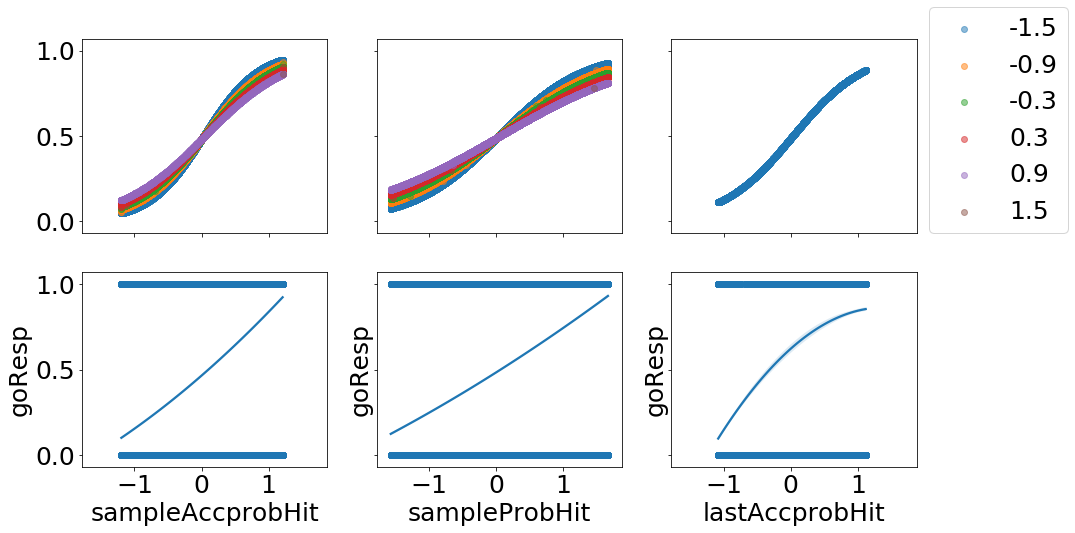

In [35]:
# plot the two predicitons
fig_predict, axs_predict = plt.subplots(2,3, figsize = (3 * width + 2 * gaps , 2 * height), sharex = True, sharey = True)

# in case of the time resolved models, let's colour by time:
windows = np.linspace(min(normal_long_df.sampleTimeMsGo), max(normal_long_df.sampleTimeMsGo), 6)
steps = np.unique(np.diff(windows))
for tw in windows:
    idx = np.where((normal_long_df.sampleTimeMsGo >= tw) & (normal_long_df.sampleTimeMsGo < (tw+steps)[0]))
    axs_predict[0,0].scatter(normal_long_df.loc[idx[0],'sampleAccprobHit'],np.array(m4_accumulated_ypred)[idx], alpha = 0.5, label = np.round(tw, 1))
    axs_predict[0,1].scatter(normal_long_df.loc[idx[0],'sampleProbHit'],np.array(m4_individual_ypred)[idx], alpha = 0.5, label = np.round(tw,1))

axs_predict[0,1].legend(loc = (2.25, 0.0))
# and, as a reminder the two behaviour-based seaborn plots
axs_predict[0,2].scatter(normal_df.lastAccprobHit, m1_accumulatedlast_ypred)


sb.regplot(normal_long_df.sampleAccprobHit, normal_long_df.goResp, order = 2, ax = axs_predict[1,0])
sb.regplot(normal_long_df.sampleProbHit, normal_long_df.goResp, order = 2, ax = axs_predict[1,1])
sb.regplot(normal_df.lastAccprobHit, normal_df.goResp, order = 2, ax = axs_predict[1,2]);

### Conclusion from ideal observer and linear behavioural fit

The most accurate responses can be obtained when making a decision based on the accumulated probability. But both, models for Accumulated and Individual probability fit the responses, Accumulated Probability varies over a smaller range, but that does not allow us to conclude for/against it's superiority compared to the individual probes.

Using only the last seen accumulated probability has several downsides: 
1. we can't look at temporal dynamics
2. we take the last value just before a response. This, however does not considers human response delays or alike.

This measure is therefore not optimal all will from now on be excluded.

Above, we have established that there seems to be an important interaction between time and the decision parameter.
However, due to the structuure of our model, we force this interaction to be linear. This explains why in our model, the earliest time point has the steepest slope and all other time points follow in order. The assumption of linearity can, however not be true. The main reason is that we expect the influence of time points presented AFTER a response to drop to 0.

This irregular dynamics can be captured by returning to the wide format model and fitting the responses to every time window individually. By doing so, we explicitly include the interaction between decision value and time, but our analysis above has shown that it's legitimate to do so.

We will in the following analysis drop the random effect for the decision variable, because of computational power and because the AIC suggests that benefits from including these random effects are low.

In [36]:
# first, we normalize the wide format predictors
for n in range(1,7):
    normal_df.loc[:,'sampleAccprobHit_0{}'.format(n)] = normalize(normal_df.loc[:,'sampleAccprobHit_0{}'.format(n)].values)
    normal_df.loc[:,'sampleProbHit_0{}'.format(n)] = normalize(normal_df.loc[:,'sampleProbHit_0{}'.format(n)].values)


In [37]:
# fitting wide models with all parameters
# for the accumulated probabilities

mw_accumulated = Lmer('goResp ~ sampleAccprobHit_01 + sampleAccprobHit_02 + sampleAccprobHit_03 + sampleAccprobHit_04 + sampleAccprobHit_05 + sampleAccprobHit_06 +(1|subject)', data = normal_df, family = 'binomial')
mw_accumulated.fit()

Formula: goResp~sampleAccprobHit_01+sampleAccprobHit_02+sampleAccprobHit_03+sampleAccprobHit_04+sampleAccprobHit_05+sampleAccprobHit_06+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 9589	 Groups: {'subject': 4.0}

Log-likelihood: -3292.727 	 AIC: 6601.454

Random effects:

                Name    Var    Std
subject  (Intercept)  0.355  0.595

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.057,-0.644,0.530,0.299,0.945,0.525,1.699,0.486,0.344,0.629,-0.190,0.849,
sampleAccprobHit_01,0.468,0.365,0.572,0.053,1.598,1.440,1.772,0.615,0.590,0.639,8.852,0.000,***
sampleAccprobHit_02,1.154,1.007,1.302,0.075,3.172,2.737,3.677,0.760,0.732,0.786,15.324,0.000,***
sampleAccprobHit_03,0.684,0.497,0.871,0.096,1.982,1.643,2.390,0.665,0.622,0.705,7.161,0.000,***
sampleAccprobHit_04,-0.003,-0.260,0.253,0.131,0.997,0.771,1.288,0.499,0.435,0.563,-0.026,0.979,
sampleAccprobHit_05,-0.266,-0.624,0.092,0.182,0.767,0.536,1.096,0.434,0.349,0.523,-1.457,0.145,
sampleAccprobHit_06,0.590,0.299,0.881,0.148,1.803,1.348,2.412,0.643,0.574,0.707,3.972,0.000,***


In [38]:
# fitting wide models with all parameters
# for the individual probabilities

mw_individual = Lmer('goResp ~ sampleProbHit_01 + sampleProbHit_02 + sampleProbHit_03 + sampleProbHit_04 + sampleProbHit_05 + sampleProbHit_06 +(1|subject)', data = normal_df, family = 'binomial')
mw_individual.fit()

Formula: goResp~sampleProbHit_01+sampleProbHit_02+sampleProbHit_03+sampleProbHit_04+sampleProbHit_05+sampleProbHit_06+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 9589	 Groups: {'subject': 4.0}

Log-likelihood: -3296.101 	 AIC: 6608.201

Random effects:

                Name    Var    Std
subject  (Intercept)  0.342  0.585

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.092,-0.669,0.484,0.294,0.912,0.512,1.622,0.477,0.339,0.619,-0.314,0.753,
sampleProbHit_01,1.328,1.245,1.410,0.042,3.773,3.474,4.097,0.790,0.776,0.804,31.564,0.000,***
sampleProbHit_02,1.175,1.095,1.255,0.041,3.239,2.990,3.508,0.764,0.749,0.778,28.867,0.000,***
sampleProbHit_03,0.592,0.518,0.666,0.038,1.808,1.678,1.947,0.644,0.627,0.661,15.609,0.000,***
sampleProbHit_04,0.111,0.038,0.184,0.037,1.117,1.039,1.202,0.528,0.510,0.546,2.993,0.003,**
sampleProbHit_05,0.114,0.042,0.187,0.037,1.121,1.042,1.206,0.529,0.510,0.547,3.079,0.002,**
sampleProbHit_06,0.164,0.092,0.237,0.037,1.179,1.096,1.267,0.541,0.523,0.559,4.451,0.000,***


The wide data analysis finds a significant relationship between every time point and the response. (Apart from two time points 4/5 in the accumulated probability). While we don't expect an influence, the correlation can be explained by the fact that at any given time point, the probability values are drawn from a distribution that reflects the true outcome of the experiment. So as long as participants make mainly correct decisions, we would expect a correlation between decision and probability at any given time point. We can control for this by including the true outcome of the experiment as an additional predictor

In [39]:
mw_accumulated_hitGoal = Lmer('goResp ~ sampleAccprobHit_01 + sampleAccprobHit_02 + sampleAccprobHit_03 + sampleAccprobHit_04 + sampleAccprobHit_05 + sampleAccprobHit_06 + hitGoal +(1|subject)', data = normal_df, family = 'binomial')
mw_accumulated_hitGoal.fit()

Formula: goResp~sampleAccprobHit_01+sampleAccprobHit_02+sampleAccprobHit_03+sampleAccprobHit_04+sampleAccprobHit_05+sampleAccprobHit_06+hitGoal+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 9589	 Groups: {'subject': 4.0}

Log-likelihood: -3286.687 	 AIC: 6591.375

Random effects:

                Name    Var    Std
subject  (Intercept)  0.355  0.596

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.413,-1.034,0.208,0.317,0.661,0.355,1.231,0.398,0.262,0.552,-1.305,0.192,
sampleAccprobHit_01,0.467,0.363,0.571,0.053,1.595,1.438,1.769,0.615,0.590,0.639,8.817,0.000,***
sampleAccprobHit_02,1.154,1.007,1.302,0.075,3.171,2.737,3.675,0.760,0.732,0.786,15.342,0.000,***
sampleAccprobHit_03,0.683,0.496,0.871,0.095,1.981,1.643,2.388,0.664,0.622,0.705,7.159,0.000,***
sampleAccprobHit_04,0.004,-0.252,0.261,0.131,1.004,0.777,1.298,0.501,0.437,0.565,0.032,0.975,
sampleAccprobHit_05,-0.258,-0.615,0.099,0.182,0.773,0.541,1.105,0.436,0.351,0.525,-1.414,0.157,
sampleAccprobHit_06,0.222,-0.135,0.580,0.182,1.249,0.874,1.786,0.555,0.466,0.641,1.219,0.223,
hitGoal,0.714,0.309,1.120,0.207,2.043,1.362,3.064,0.671,0.577,0.754,3.454,0.001,***


In [40]:
mw_individual_hitGoal = Lmer('goResp ~ sampleProbHit_01 + sampleProbHit_02 + sampleProbHit_03 + sampleProbHit_04 + sampleProbHit_05 + sampleProbHit_06 + hitGoal +(1|subject)', data = normal_df, family = 'binomial')
mw_individual_hitGoal.fit()

Formula: goResp~sampleProbHit_01+sampleProbHit_02+sampleProbHit_03+sampleProbHit_04+sampleProbHit_05+sampleProbHit_06+hitGoal+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 9589	 Groups: {'subject': 4.0}

Log-likelihood: -3261.711 	 AIC: 6541.421

Random effects:

                Name    Var    Std
subject  (Intercept)  0.353  0.594

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.604,-1.202,-0.005,0.305,0.547,0.301,0.995,0.354,0.231,0.499,-1.977,0.048,*
sampleProbHit_01,1.235,1.149,1.321,0.044,3.438,3.156,3.746,0.775,0.759,0.789,28.268,0.000,***
sampleProbHit_02,1.067,0.983,1.151,0.043,2.905,2.671,3.160,0.744,0.728,0.760,24.881,0.000,***
sampleProbHit_03,0.461,0.380,0.542,0.041,1.586,1.462,1.719,0.613,0.594,0.632,11.150,0.000,***
sampleProbHit_04,-0.030,-0.111,0.051,0.041,0.970,0.895,1.052,0.492,0.472,0.513,-0.727,0.467,
sampleProbHit_05,-0.022,-0.103,0.058,0.041,0.978,0.902,1.060,0.494,0.474,0.515,-0.547,0.584,
sampleProbHit_06,0.031,-0.049,0.111,0.041,1.031,0.952,1.117,0.508,0.488,0.528,0.758,0.448,
hitGoal,1.034,0.787,1.280,0.126,2.812,2.198,3.598,0.738,0.687,0.783,8.222,0.000,***


In [41]:
mw_individual_final = Lmer('goResp ~ sampleProbHit_01 + sampleProbHit_02 + sampleProbHit_03 + hitGoal +(1|subject)', data = normal_df, family = 'binomial')
mw_individual_final.fit()

Formula: goResp~sampleProbHit_01+sampleProbHit_02+sampleProbHit_03+hitGoal+(1|subject)

Family: binomial	 Inference: parametric

Number of observations: 9589	 Groups: {'subject': 4.0}

Log-likelihood: -3262.409 	 AIC: 6536.818

Random effects:

                Name    Var    Std
subject  (Intercept)  0.353  0.594

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.589,-1.181,0.002,0.302,0.555,0.307,1.002,0.357,0.235,0.501,-1.952,0.051,.
sampleProbHit_01,1.234,1.148,1.320,0.044,3.435,3.153,3.742,0.775,0.759,0.789,28.261,0.000,***
sampleProbHit_02,1.067,0.983,1.151,0.043,2.907,2.672,3.161,0.744,0.728,0.760,24.900,0.000,***
sampleProbHit_03,0.461,0.380,0.542,0.041,1.586,1.462,1.720,0.613,0.594,0.632,11.154,0.000,***
hitGoal,1.006,0.833,1.178,0.088,2.734,2.300,3.249,0.732,0.697,0.765,11.409,0.000,***


In [42]:
#mw_individual_final.coefs.to_csv('Lmer_responsetype.csv')

Including the true outcome of the trial reduces the number of time windows that have a significant correlation with the response. Now, both models indicate that only the first 3 time windows and the additional information of the true outcome of the experiment are needed to predict the response. 

Next, we can visualize this.

Conclusion: 
the y-axis describes the natural logarithm of the ratio between go and no-go responses. This graphic also exposes one major problem with the design:

accumulated probabilites above normalized 0.5 only occur in real "hit" trial
and individaul probabilities above 0.75 only occur in real "hit" trials 

Also, in the accumulated case, the variance of values get smaller.

For future studies, we need to make sure, that the distributions in hit vs pass trials are closer together and have more overlap.

The two models make different predicitons which time window is the most important in driving the response. 
While the accumulated model suggests that the second time window has the strongest correlation with the response, the individual model ranks time window one and two as important, with time window one having more influence than time window two.

The importance of time window two in the accumulated case can be explained by the fact that while modelling accumulated probabilties, we always compute each time window as based on previous time windows. Time window two therefore contains information from 1 and two. Also tw 2 is the first time window when information cannot be redundant to earlier information. Time window 2, might take a away from the first time window.

Because of the temporal confound and the hidden interactions induced by the accumulated model, we will, for the rest of this analysis focus on the individual probabilities.

3. Time window description

In this part of the notebook, I'll do a deeper dive on how different time windows influence the decision (go/nogo). 
I'll look at two different values:
1. contrast go/nogo decisions in different settings 
2. check what happens when very differnt information are shown from one timepoint to the next.

Both approaches will be done with with a forward approach and a backward approach (from go signal onset, and from response onset)
For covenience, we will return to the long data format here, because it allows us to compute time intervals based on one column.

In [43]:
long_df.loc[np.where((long_df.subject == s) & (long_df.goResp == 0))[0],'rea_time']

Series([], Name: rea_time, dtype: float64)

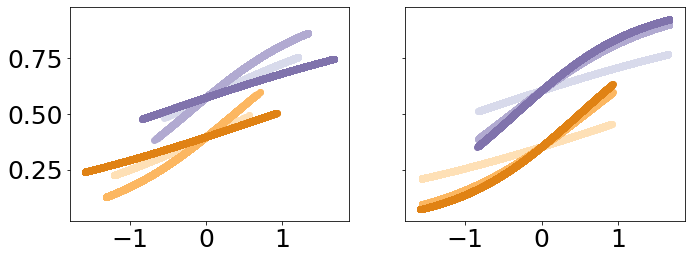

In [44]:
# make subplot grid
fig_widemodels, axs_widemodels = plt.subplots(1,2, figsize = (2 * width + 2 * gaps , height), sharex = True, sharey = True)

# data for m1 and m2
#mw_accumulated_ypred = mw_accumulated_hitGoal.predict(normal_df)
#mw_individual_ypred = mw_individual_hitGoal.predict(normal_df)

# compute the probability of respose odds based on only one time 
def get_prediction(estimates, predictor, data, sigmoid = True):
    b_0 = estimates.loc['(Intercept)','Estimate']
    b_1 = estimates.loc[predictor, 'Estimate']
    b_2 = estimates.loc['hitGoal', 'Estimate']
    
    ln_odds = b_0 + b_1 * data[predictor] + b_2 * data['hitGoal']
    if sigmoid:
        prediction = 1/(1+np.exp(-ln_odds.values))
    else:
        prediction = ln_odds
    
    return prediction

# plot data for hit/nohit
for state, c in zip(np.unique(normal_df.hitGoal), [-1, 1]):
    
    state_data = normal_df.loc[normal_df.hitGoal == state,:]
    
    for estimate, a in zip(['sampleAccprobHit_03', 'sampleAccprobHit_02', 'sampleAccprobHit_01'], c_cm(np.linspace(0.5 + c*0.1, 0.5+c*0.3, 3))):
        pred = get_prediction(mw_accumulated_hitGoal.coefs, estimate, state_data)
        axs_widemodels[0].scatter(state_data[estimate], pred, color = a)
    
    for estimate, a in zip(['sampleProbHit_03', 'sampleProbHit_02', 'sampleProbHit_01'], c_cm(np.linspace(0.5+c*0.1, 0.5+c*0.3, 3))):
        pred = get_prediction(mw_individual_hitGoal.coefs, estimate, state_data)
        axs_widemodels[1].scatter(state_data[estimate], pred, color = a)
        

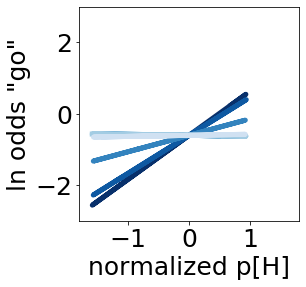

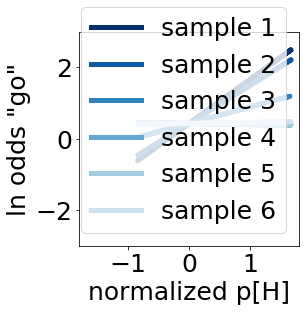

In [45]:
# for the poster, I only want the simple response model
# make subplot grid
fig_response_modelPass, axs_response_modelPass = plt.subplots(1,1, figsize = (width * 1, height* 1))
fig_response_modelHit, axs_response_modelHit = plt.subplots(1,1, figsize = (width* 1, height* 1))

axs_response_model = [axs_response_modelPass, axs_response_modelHit]

# plot the data for each subject

# for sid, s in enumerate(np.unique(normal_df.subject)):
    
#     s_df = normal_df[normal_df.subject == s]
#     s_coefs = mw_individual_hitGoal.fixef.loc[sid, :]
    
#     # plot data for hit/nohit
#     for state in np.unique(s_df.hitGoal):

#         state_data = s_df.loc[normal_df.hitGoal == state,:]

#         for estimate, c in zip([1,2,3,4,5,6], t_cm):
#             pred = s_coefs['(Intercept)']+s_coefs['sampleProbHit_0{}'.format(estimate)]*state_data['sampleProbHit_0{}'.format(estimate)]+s_coefs['hitGoal']*state_data['hitGoal']
#             #pred = 1/(1+np.exp(-pred))
#             #print(state_data[estimate])
#             axs_response_model[state].plot(state_data['sampleProbHit_0{}'.format(estimate)], pred, color = c, alpha = 0.3)

# plot data for hit/nohit
for state in np.unique(normal_df.hitGoal):
    
    state_data = normal_df.loc[normal_df.hitGoal == state,:]
    
    for estimate, c in zip([1,2,3,4,5,6], t_cm):
        pred = get_prediction(mw_individual_hitGoal.coefs, 'sampleProbHit_0{}'.format(estimate), state_data, sigmoid = False)
        axs_response_model[state].plot(state_data['sampleProbHit_0{}'.format(estimate)], pred, color = c, label = 'sample {}'.format(estimate), linewidth = 5)
    
        
#axs_response_model.set_title('linear response model')
axs_response_model[0].set_ylabel('ln odds "go"')
axs_response_model[0].set_xlabel('normalized p[H]')
axs_response_model[0].set_ylim([-3,3])
axs_response_model[0].set_xlim([-1.8,1.8])


axs_response_model[1].set_ylabel('ln odds "go"')
axs_response_model[1].set_xlabel('normalized p[H]')
axs_response_model[1].set_ylim([-3,3])
axs_response_model[1].set_xlim([-1.8,1.8])

#axs_response_model[0].set_title('"pass" trials')
#axs_response_model[1].set_title('"hit" trials')
axs_response_model[1].legend(loc = 'lower right')


fig_response_modelPass.savefig(path_figs+"LinearModelResponsesPass.pdf", bbox_inches='tight')
fig_response_modelHit.savefig(path_figs+"LinearModelResponsesHit.pdf", bbox_inches='tight')

In [46]:
# add needed measures:
# in the non-normalized data frame:

# simulate response times for no-go responses as the mean response time for each participant
for s in np.unique(long_df.subject):
    s_rt = np.nanmean(long_df[long_df.subject == s].rea_time)
    long_df.loc[np.where((long_df.subject == s) & (long_df.goResp == 0))[0],'rea_time'] = s_rt

# transform the timing column in the second space
long_df['sampleTimeSecGo'] = long_df.sampleTimeMsGo/1000

# get the timing relative to the response
long_df['sampleTimeSecResp'] = long_df.sampleTimeSecGo - long_df.rea_time

# check how long before a response the stimuli were presented
long_df.groupby('sampleID').describe().sampleTimeSecResp

# add model predicitons to the long data frame
predicted = np.array(mw_individual_final.predict(normal_df))
predicted_long = np.repeat(predicted,6)
long_df['predictedResponse'] = [int(x) for x in (predicted_long>0.5)]
long_df['predictedAnswer'] = 1-(abs(long_df.predictedResponse-long_df.hitGoal))

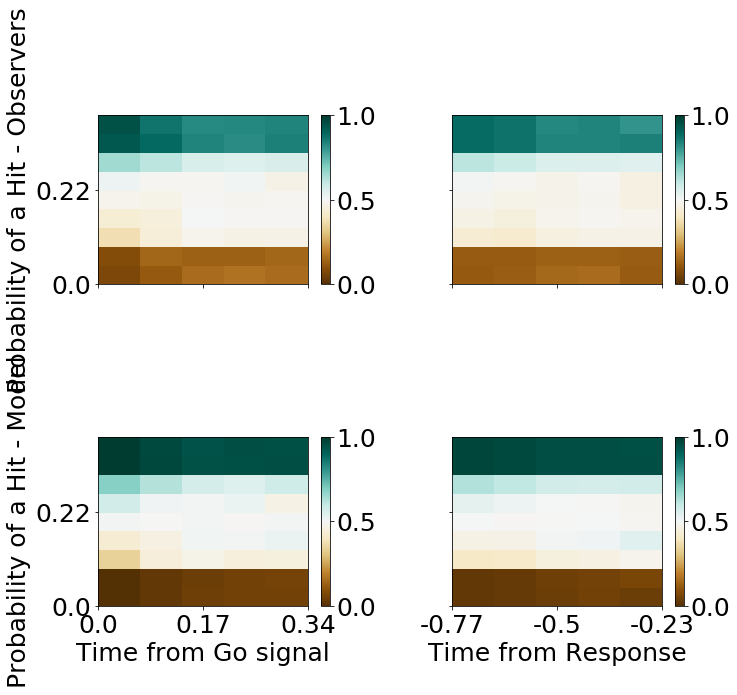

In [47]:
# with those two values, we can now compute the average value of a sample 
# at time x after the "go" signal or before the response

# first: which response results from a value x at time y - tileplot
fig_value_response, axs_value_response = plt.subplots(2,2, figsize = (2*width + 2 * gaps,2* height + gaps), sharex = 'col', sharey = True)

# the time windows
n_twins = 6
window_forward = np.linspace(min(long_df.sampleTimeSecGo), max(long_df.sampleTimeSecGo), n_twins)
window_backward = np.linspace(min(long_df.sampleTimeSecResp), max(long_df.sampleTimeSecResp), n_twins)

# get the hit probabilities in this time window
n_pwins = 10
window_prob = np.linspace(min(long_df.sampleProbHit),max(long_df.sampleProbHit),n_pwins)

# initialize the data frames

# go/nogo responses of human observers
resp_fw_df = pd.DataFrame() 
resp_bw_df = pd.DataFrame() 

# go/nogo responses of the model
mresp_fw_df = pd.DataFrame()
mresp_bw_df = pd.DataFrame()

# correct/incorrect responses of the observers
ans_fw_df = pd.DataFrame() 
ans_bw_df = pd.DataFrame() 

# correct/incorrect responses of the model
mans_fw_df = pd.DataFrame()
mans_bw_df = pd.DataFrame()

for timewin in range(0,n_twins-1):
    
    # get the upper and lower boundaries for the time window
    forward_lowerbound = window_forward[timewin]
    backward_lowerbound = window_backward[timewin]  
    
    forward_upperbound = window_forward[timewin+1]
    backward_upperbound = window_forward[timewin+1]
    
    # reduce the data frame
    forward_df = long_df.loc[np.where((long_df.sampleTimeSecGo>=forward_lowerbound) &(long_df.sampleTimeSecGo<forward_upperbound))]
    backward_df = long_df.loc[np.where((long_df.sampleTimeSecResp>=backward_lowerbound) &(long_df.sampleTimeSecResp<backward_upperbound))]

    for probwin in range(0, n_pwins-1):
        # get the upper and lower probability values
        prob_lowerbound = window_prob[probwin]
        prob_upperbound = window_prob[probwin + 1]
        
        # reduce the data frame
        forward_prob_df = forward_df.iloc[np.where((forward_df.sampleProbHit>=prob_lowerbound) & (forward_df.sampleProbHit<prob_upperbound))]
        backward_prob_df = backward_df.iloc[np.where((backward_df.sampleProbHit>=prob_lowerbound) & (backward_df.sampleProbHit<prob_upperbound))]

        # write the important values to the array
        resp_fw_df.loc[window_prob[probwin],window_forward[timewin]] = np.mean(forward_prob_df.goResp)
        resp_bw_df.loc[window_prob[probwin],window_backward[timewin]] = np.mean(backward_prob_df.goResp)
        
        ans_fw_df.loc[window_prob[probwin],window_forward[timewin]] = np.mean(forward_prob_df.answer)
        ans_bw_df.loc[window_prob[probwin],window_backward[timewin]] = np.mean(backward_prob_df.answer)
        
        # and for the modelled responses
        mresp_fw_df.loc[window_prob[probwin],window_forward[timewin]] = np.mean(forward_prob_df.predictedResponse)
        mresp_bw_df.loc[window_prob[probwin],window_backward[timewin]] = np.mean(backward_prob_df.predictedResponse)
        
        mans_fw_df.loc[window_prob[probwin],window_forward[timewin]] = np.mean(forward_prob_df.predictedAnswer)
        mans_bw_df.loc[window_prob[probwin],window_backward[timewin]] = np.mean(backward_prob_df.predictedAnswer)
        
        
# make plots
#responses_forward_df.reset_index(drop = True, inplace = True)
p1 = axs_value_response[0,0].pcolormesh(resp_fw_df, cmap = g_cm, vmin = 0, vmax = 1)
p2 = axs_value_response[0,1].pcolormesh(resp_bw_df, cmap = g_cm, vmin = 0, vmax = 1)

p3 = axs_value_response[1,0].pcolormesh(mresp_fw_df, cmap = g_cm, vmin = 0, vmax = 1)
p4 = axs_value_response[1,1].pcolormesh(mresp_bw_df, cmap = g_cm, vmin = 0, vmax = 1)

axs_value_response[0,0].set_xticklabels(np.round(window_forward, 2))
axs_value_response[0,1].set_xticklabels(np.round(window_backward, 2))
axs_value_response[1,0].set_xticklabels(np.round(window_forward, 2))
axs_value_response[1,1].set_xticklabels(np.round(window_backward, 2))

axs_value_response[0,0].set_yticklabels(np.round(resp_fw_df.index, 2)[::2])
axs_value_response[0,1].set_yticklabels(np.round(resp_bw_df.index, 2)[::2])
axs_value_response[1,0].set_yticklabels(np.round(mresp_fw_df.index, 2)[::2])
axs_value_response[1,1].set_yticklabels(np.round(mresp_bw_df.index, 2)[::2])

#axs_value_response[0,0].set_title("T0 = 'GO'")
#axs_value_response[0,1].set_title("T0 = response")
axs_value_response[0,0].set_ylabel('Probability of a Hit - Observers')
axs_value_response[1,0].set_ylabel('Probability of a Hit - Model')
axs_value_response[1,0].set_xlabel('Time from Go signal')
axs_value_response[1,1].set_xlabel('Time from Response')

fig_value_response.colorbar(p1, ax=axs_value_response[0,0])
fig_value_response.colorbar(p2, ax=axs_value_response[0,1])
fig_value_response.colorbar(p3, ax=axs_value_response[1,0])
fig_value_response.colorbar(p4, ax=axs_value_response[1,1])

## to do: add a comparison with the model
## get a reaction time estimate for nogo responses
## same analysis for correct/incorrect responses
plt.tight_layout()

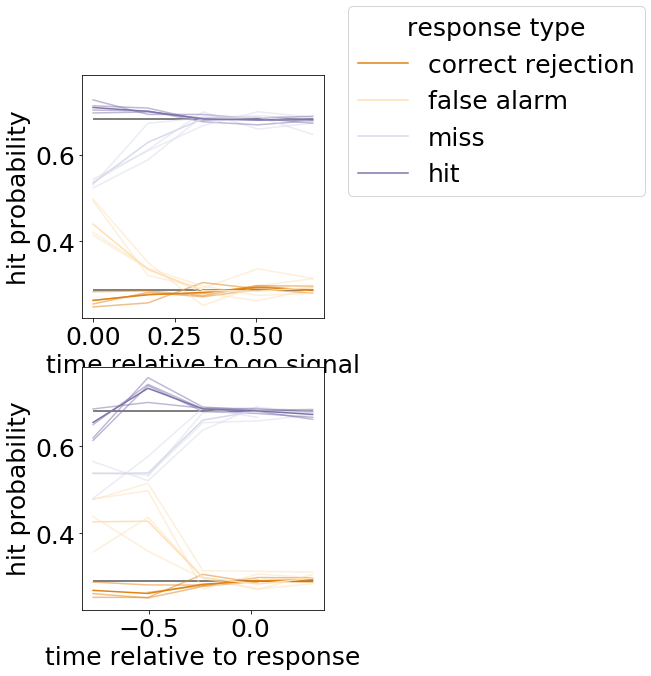

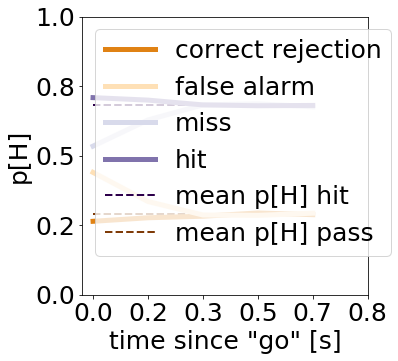

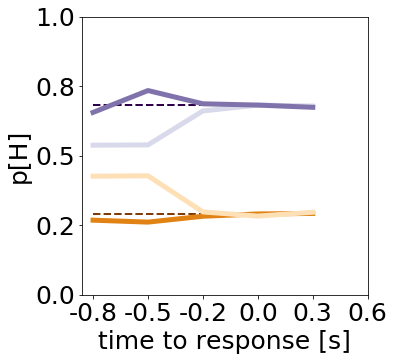

In [48]:
# what were the mean values observed at each time window before different response categories - line plot

responses = ['CORRECT REJECTION', 'FALSE ALARM', 'MISS', 'HIT']

# initialize data frames
value_respcat_fw = pd.DataFrame()
value_respcat_bw = pd.DataFrame()

# initialize plots
fig_response_cats, axs_response_cats = plt.subplots(2,1, figsize = (1.1 * width, 2.5 * height), sharey = True)

VVSS2021_forwardCorr, axs_fwcorr = plt.subplots(1,1, figsize = (width* 1.3,height* 1.3))
VVSS2021_backwardCorr, axs_bwcorr = plt.subplots(1,1, figsize = (width* 1.3,height* 1.3))


for s in np.unique(long_df.subject):

    s_df = long_df[long_df.subject == s].reset_index(drop = True)
    # loop though time windows
    for timewin in range(0,n_twins-1):
        #print(window_backward[timewin])
        timewin_fw_df = s_df.loc[np.where((s_df.sampleTimeSecGo>=window_forward[timewin]) & (s_df.sampleTimeSecGo<window_forward[timewin+1]))]
        timewin_bw_df = s_df.loc[np.where((s_df.sampleTimeSecResp>=window_backward[timewin]) & (s_df.sampleTimeSecResp<window_backward[timewin+1]))]

        # loop through response categories
        for respcat in responses:
            # get mean probability for category and time value
            value_respcat_fw.loc[respcat,window_forward[timewin]] = np.nanmean(timewin_fw_df[timewin_fw_df.response_cat == respcat].sampleProbHit)
            value_respcat_bw.loc[respcat,window_backward[timewin]] = np.nanmean(timewin_bw_df[timewin_bw_df.response_cat == respcat].sampleProbHit)



    # plot
    for row, c in zip(responses, plt.cm.get_cmap('PuOr')(np.linspace(0.2, 0.8, len(responses)))):
        axs_response_cats[0].plot(window_forward[:-1],value_respcat_fw.loc[row,:], color = c, alpha = 0.5)
        axs_response_cats[1].plot(window_backward[:-1],value_respcat_bw.loc[row,:], color = c, alpha = 0.5)
        
# add the mean of all subjects:

for timewin in range(0,n_twins-1):
    #print(window_backward[timewin])
    timewin_fw_df = long_df.loc[np.where((long_df.sampleTimeSecGo>=window_forward[timewin]) & (long_df.sampleTimeSecGo<window_forward[timewin+1]))]
    timewin_bw_df = long_df.loc[np.where((long_df.sampleTimeSecResp>=window_backward[timewin]) & (long_df.sampleTimeSecResp<window_backward[timewin+1]))]

    # loop through response categories
    for respcat in responses:
        # get mean probability for category and time value
        value_respcat_fw.loc[respcat,window_forward[timewin]] = np.nanmean(timewin_fw_df[timewin_fw_df.response_cat == respcat].sampleProbHit)
        value_respcat_bw.loc[respcat,window_backward[timewin]] = np.nanmean(timewin_bw_df[timewin_bw_df.response_cat == respcat].sampleProbHit)

# plot
for row, c in zip(responses, plt.cm.get_cmap('PuOr')(np.linspace(0.2, 0.8, len(responses)))):
    axs_response_cats[0].plot(window_forward[:-1],value_respcat_fw.loc[row,:], color = c, label = row.lower())
    axs_response_cats[0].hlines(np.mean(long_df[long_df.hitGoal == 1].sampleProbHit), xmin = 0, xmax = max(window_forward[:-1]), color = 'grey')
    axs_response_cats[0].hlines(np.mean(long_df[long_df.hitGoal == 0].sampleProbHit), xmin = 0, xmax = max(window_forward[:-1]), color = 'grey')
    axs_response_cats[1].plot(window_backward[:-1],value_respcat_bw.loc[row,:], color = c)
    axs_response_cats[1].hlines(np.mean(long_df[long_df.hitGoal == 1].sampleProbHit), xmin = min(window_backward[:-1]), xmax = max(window_backward[:-1]), color = 'grey')
    axs_response_cats[1].hlines(np.mean(long_df[long_df.hitGoal == 0].sampleProbHit), xmin = min(window_backward[:-1]), xmax = max(window_backward[:-1]), color = 'grey')
    
    axs_fwcorr.plot(window_forward[:-1],value_respcat_fw.loc[row,:], color = c, label = row.lower(), linewidth = 5)
    axs_bwcorr.plot(window_backward[:-1],value_respcat_bw.loc[row,:], color = c, linewidth = 5)
axs_fwcorr.hlines(np.mean(long_df[long_df.hitGoal == 1].sampleProbHit), xmin = 0, xmax = max(window_forward[:-1]), color = c_cm(np.linspace(0,1,2)[1]), linewidth = 2, label = 'mean p[H] hit', linestyle = '--')
axs_fwcorr.hlines(np.mean(long_df[long_df.hitGoal == 0].sampleProbHit), xmin = 0, xmax = max(window_forward[:-1]), color = c_cm(np.linspace(0,1,2)[0]), linewidth = 2, label = 'mean p[H] pass', linestyle = '--')
axs_bwcorr.hlines(np.mean(long_df[long_df.hitGoal == 1].sampleProbHit), xmin = min(window_backward[:-1]), xmax = max(window_backward[:-1]),  color = c_cm(np.linspace(0,1,2)[1]), linewidth = 2, linestyle = '--')
axs_bwcorr.hlines(np.mean(long_df[long_df.hitGoal == 0].sampleProbHit), xmin = min(window_backward[:-1]), xmax = max(window_backward[:-1]),  color = c_cm(np.linspace(0,1,2)[0]), linewidth = 2, linestyle = '--')

    
axs_response_cats[0].legend(loc =(1.1, 0.5) ,title = 'response type')

#fig_response_cats.suptitle('Hit probability before response')
axs_response_cats[0].set_ylabel('hit probability')
axs_response_cats[1].set_ylabel('hit probability')

axs_response_cats[0].set_xlabel('time relative to go signal')
axs_response_cats[1].set_xlabel('time relative to response');


axs_fwcorr.legend(loc = 'upper left')

# set labels for individual plots
axs_fwcorr.set_ylabel('p[H]')
axs_bwcorr.set_ylabel('p[H]')

axs_fwcorr.set_xlabel('time since "go" [s]')
axs_bwcorr.set_xlabel('time to response [s]')

axs_fwcorr.set_xticks(window_forward)
axs_fwcorr.set_xticklabels(np.round(window_forward, 1))

axs_bwcorr.set_xticks(window_backward)
axs_bwcorr.set_xticklabels(np.round(window_backward, 1))

axs_fwcorr.set_yticks(np.linspace(0,1,5))
axs_fwcorr.set_yticklabels(np.round(np.linspace(0,1,5), 1))

axs_bwcorr.set_yticks(np.linspace(0,1,5))
axs_bwcorr.set_yticklabels(np.round(np.linspace(0,1,5), 1))

VVSS2021_forwardCorr.savefig(path_figs+"ProbResponseForward.pdf", bbox_inches='tight')
VVSS2021_backwardCorr.savefig(path_figs+"ProbResponseBackward.pdf", bbox_inches='tight')


fig_response_cats.savefig(path_figs+"ProbByCond.pdf", bbox_inches='tight')
fig_response_cats.savefig(path_figs+"ProbByCond.png", bbox_inches='tight')

Conclusion: the probability values already start to drop 500 ms before a the go response. 
That would mean that new information is only integrated very early. Or it could mean that strong evidence for "hit" cannot be counteracted with later time windows.
We also see in the reverse correlation a sharp return of the probabilities to the baseline.

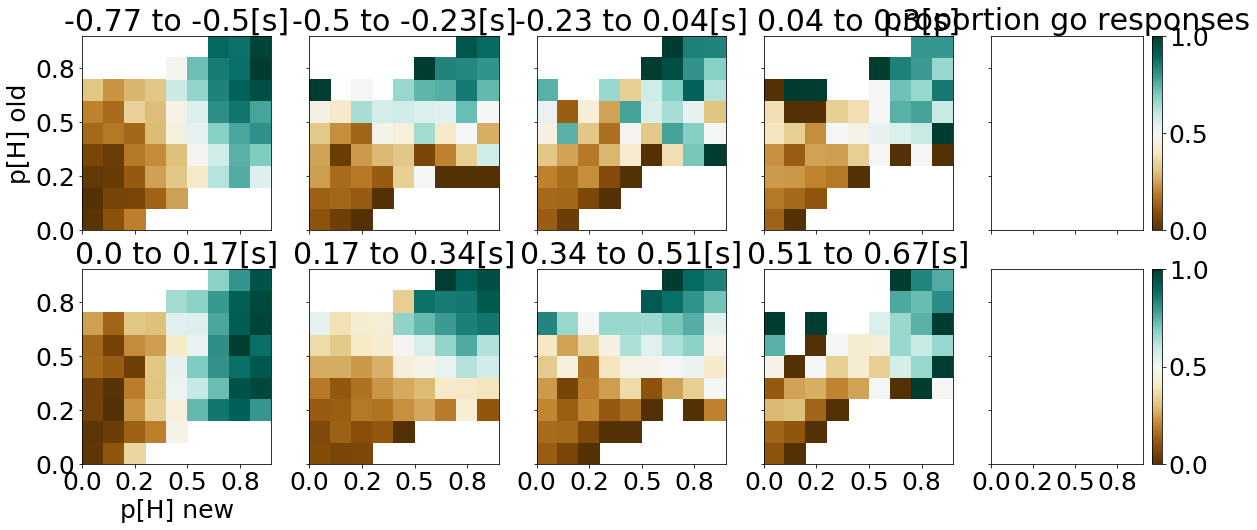

In [49]:
# what were the responses with a given change
# compute for different time windows: if the probability changed from x to y - what was the most commonly given answer?

# initialize the figure
fig_change, axs_change = plt.subplots(2, n_twins-1, figsize = ((n_twins-1) * width, 2 * height), sharex = True, sharey= True)

changes_list_fw = []
changes_list_bw = []

corr_list_fw = []
corr_list_bw = []


#window_backward = np.linspace(min(long_df.sampleTimeSecResp), max(long_df.sampleTimeSecResp), n_tw)

# make one data frame per time window
for tw in range(0, n_twins-2):
    
    # intitialize the data frames
    change_fw = pd.DataFrame()
    change_bw = pd.DataFrame()
    
    corr_fw = pd.DataFrame()
    corr_bw = pd.DataFrame()
    
    # filter data from this tw
    ctw_fw = long_df.loc[np.where((long_df.sampleTimeSecGo>=window_forward[tw]) & (long_df.sampleTimeSecGo<window_forward[tw+1]))]
    ctw_bw = long_df.loc[np.where((long_df.sampleTimeSecResp>=window_backward[tw]) & (long_df.sampleTimeSecResp<window_backward[tw+1]))]
    
    # filter data from the next tw
    ntw_fw = long_df.loc[np.where((long_df.sampleTimeSecGo>=window_forward[tw+1]) & (long_df.sampleTimeSecGo<window_forward[tw+2]))]
    ntw_bw = long_df.loc[np.where((long_df.sampleTimeSecResp>=window_backward[tw+1]) & (long_df.sampleTimeSecResp<window_backward[tw+2]))]
    
    # go through all probabilites in tw 1
    for p_start in range(0, n_pwins-1):
    
        pst_low =  window_prob[p_start]
        pst_up = window_prob[p_start + 1]
        
        # get all IDs that fullfill the trial 
        start_IDs_fw = ctw_fw.iloc[np.where((ctw_fw.sampleAccprobHit >= pst_low)&(ctw_fw.sampleAccprobHit < pst_up))[0]]['indTrial']
        start_IDs_bw = ctw_bw.iloc[np.where((ctw_bw.sampleAccprobHit >= pst_low)&(ctw_bw.sampleAccprobHit < pst_up))[0]]['indTrial']
        
        # go through all probabilities in the next time window
        for p_end in range(0, n_pwins-1):
            
            pend_low =  window_prob[p_end]
            pend_up = window_prob[p_end + 1]
            
            # get all ids that fullfill the end probability requirement
            end_IDs_fw = ntw_fw.iloc[np.where((ntw_fw.sampleAccprobHit >= pend_low)&(ntw_fw.sampleAccprobHit < pend_up))[0]]['indTrial']
            end_IDs_bw = ntw_bw.iloc[np.where((ntw_bw.sampleAccprobHit >= pend_low)&(ntw_bw.sampleAccprobHit < pend_up))[0]]['indTrial']
        
            # get the intercept between the two lists
            ID_list_fw = np.intersect1d(start_IDs_fw, end_IDs_fw)
            ID_list_bw = np.intersect1d(start_IDs_bw, end_IDs_bw)
            
            #print('backward', ID_list_bw)
            #print('forward', ID_list_fw)
            
            # filter the dataframe
            df_fw = long_df.loc[np.where(long_df.indTrial.isin(ID_list_fw))]
            # filter backward df
            df_bw = long_df.loc[np.where(long_df.indTrial.isin(ID_list_bw))]
            
            change_fw.loc[window_prob[p_start],window_prob[p_end]] = np.mean(df_fw.goResp)
            change_bw.loc[window_prob[p_start],window_prob[p_end]] = np.mean(df_bw.goResp)
            
            #corr_fw.loc[window_prob[p_start],window_prob[p_end]] = np.mean(df_fw.answer)
            #corr_bw.loc[window_prob[p_start],window_prob[p_end]] = np.mean(df_bw.answer)
    
    # save all computed data frames in one list
    changes_list_fw.append(change_fw)
    changes_list_bw.append(change_bw)
    
    #corr_list_fw.append(corr_fw)
    #corr_list_bw.append(corr_bw)
            
    # plot
    p1 = axs_change[0,tw].pcolormesh(change_fw, cmap = g_cm)
    axs_change[0,tw].set_title('{} to {}[s]'.format(np.round(window_backward[tw],2), np.round(window_backward[tw+1],2)))
    axs_change[1,tw].set_title('{} to {}[s]'.format(np.round(window_forward[tw],2), np.round(window_forward[tw+1],2)))
    axs_change[0,tw].set_xticks(np.linspace(0,10,9)[::2])
    axs_change[0,tw].set_yticklabels(np.round(np.linspace(0,1,9),1)[::2])
    axs_change[0,tw].set_yticks(np.linspace(0,10,9)[::2])
    axs_change[0,tw].set_xticklabels(np.round(np.linspace(0,1,9),1)[::2])
    p2 = axs_change[1,tw].pcolormesh(change_bw, cmap = g_cm)

axs_change[0,0].set_ylabel('p[H] old')
axs_change[1,0].set_xlabel('p[H] new')

fig_change.colorbar(p1, ax=axs_change[0,4])
axs_change[0,4].set_title('proportion go responses')
fig_change.colorbar(p2, ax=axs_change[1,4])

#plt.tight_layout()
fig_change.savefig(path_figs+"ResponseTiles.pdf", bbox_inches='tight')
fig_change.savefig(path_figs+"ResponseTiles.png", bbox_inches='tight')

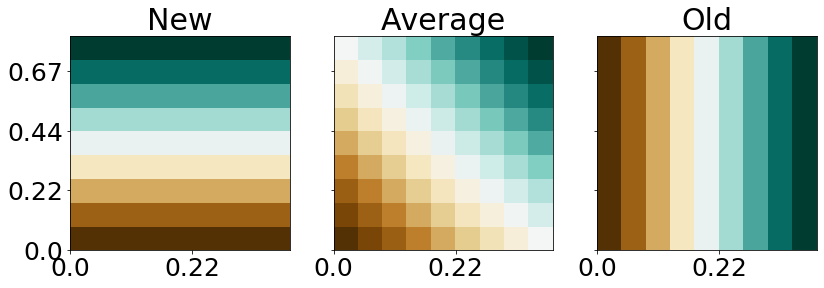

In [50]:
# model for visualization:
fig_explain_updates, axs_explain_updates = plt.subplots(1,3, figsize = (width * 3 + gaps *1, height), sharex = True,sharey = True)

# take one matrix and replace all values with nans
sample_mat = change_bw.copy()
sample_mat.loc[:,:]=np.nan

early_mat = sample_mat.copy()
late_mat = sample_mat.copy()

correct_mat = sample_mat.copy()

# assume threshold
for c in sample_mat.columns:
    
    for r in sample_mat.index:
        
        early_mat.loc[r,c] =1/(1+np.exp(-r))
        late_mat.loc[r,c] =1/(1+np.exp(-c))
        
axs_explain_updates[0].pcolormesh(early_mat, cmap = g_cm)
axs_explain_updates[1].pcolormesh((late_mat+early_mat)/2, cmap = g_cm)
axs_explain_updates[2].pcolormesh(late_mat, cmap = g_cm)


axs_explain_updates[0].set_title('New')
axs_explain_updates[1].set_title('Average')
axs_explain_updates[2].set_title('Old')

axs_explain_updates[0].set_yticklabels(np.round(early_mat.columns, 2)[::2])
axs_explain_updates[0].set_xticklabels(np.round(early_mat.columns, 2)[[0,2,5,7]])

fig_explain_updates.savefig(path_figs+"ExplainedResponseTiles.pdf", bbox_inches='tight')
fig_explain_updates.savefig(path_figs+"ExplainedResponseTiles.png", bbox_inches='tight')

Interpretation: changes in the probabilities are well integrated up to ... ms before the response.
When the response was associated with a high probability in earlier windows, the response was more often a go-response when compared to the probability being low.

4. Describe the effects of high and low probabilities on reaction times

In this part of the notebook, we describe how reaction times are influenced by high/low probabilites at different time points. We will proceed as above, using the long data format first as a proof of the influence of time. Then, we'll proceed with the wide data format, allowing for a non-linear relationship between time point and influence on the response. 

differently from the approach above, I will not use the accumulated probability, but start with individual probability directly.

Thus, the models I'll fit will be

1. response time ~ individual probability * time window * trial category (go/nogo) + (1+ ...|subject) data frame = normal_long_df
2. response time ~ individual probability t0 + individual probability t1 (...) + trial category + (1|subject) data frame = normal_df

#### Important to note: I am ONLY using go responses for this analysis

In [51]:
# step 1: get the necessary values

normal_long_go = normal_long_df[normal_long_df.goResp == 1].copy()
normal_go = normal_df[normal_df.goResp == 1].copy()

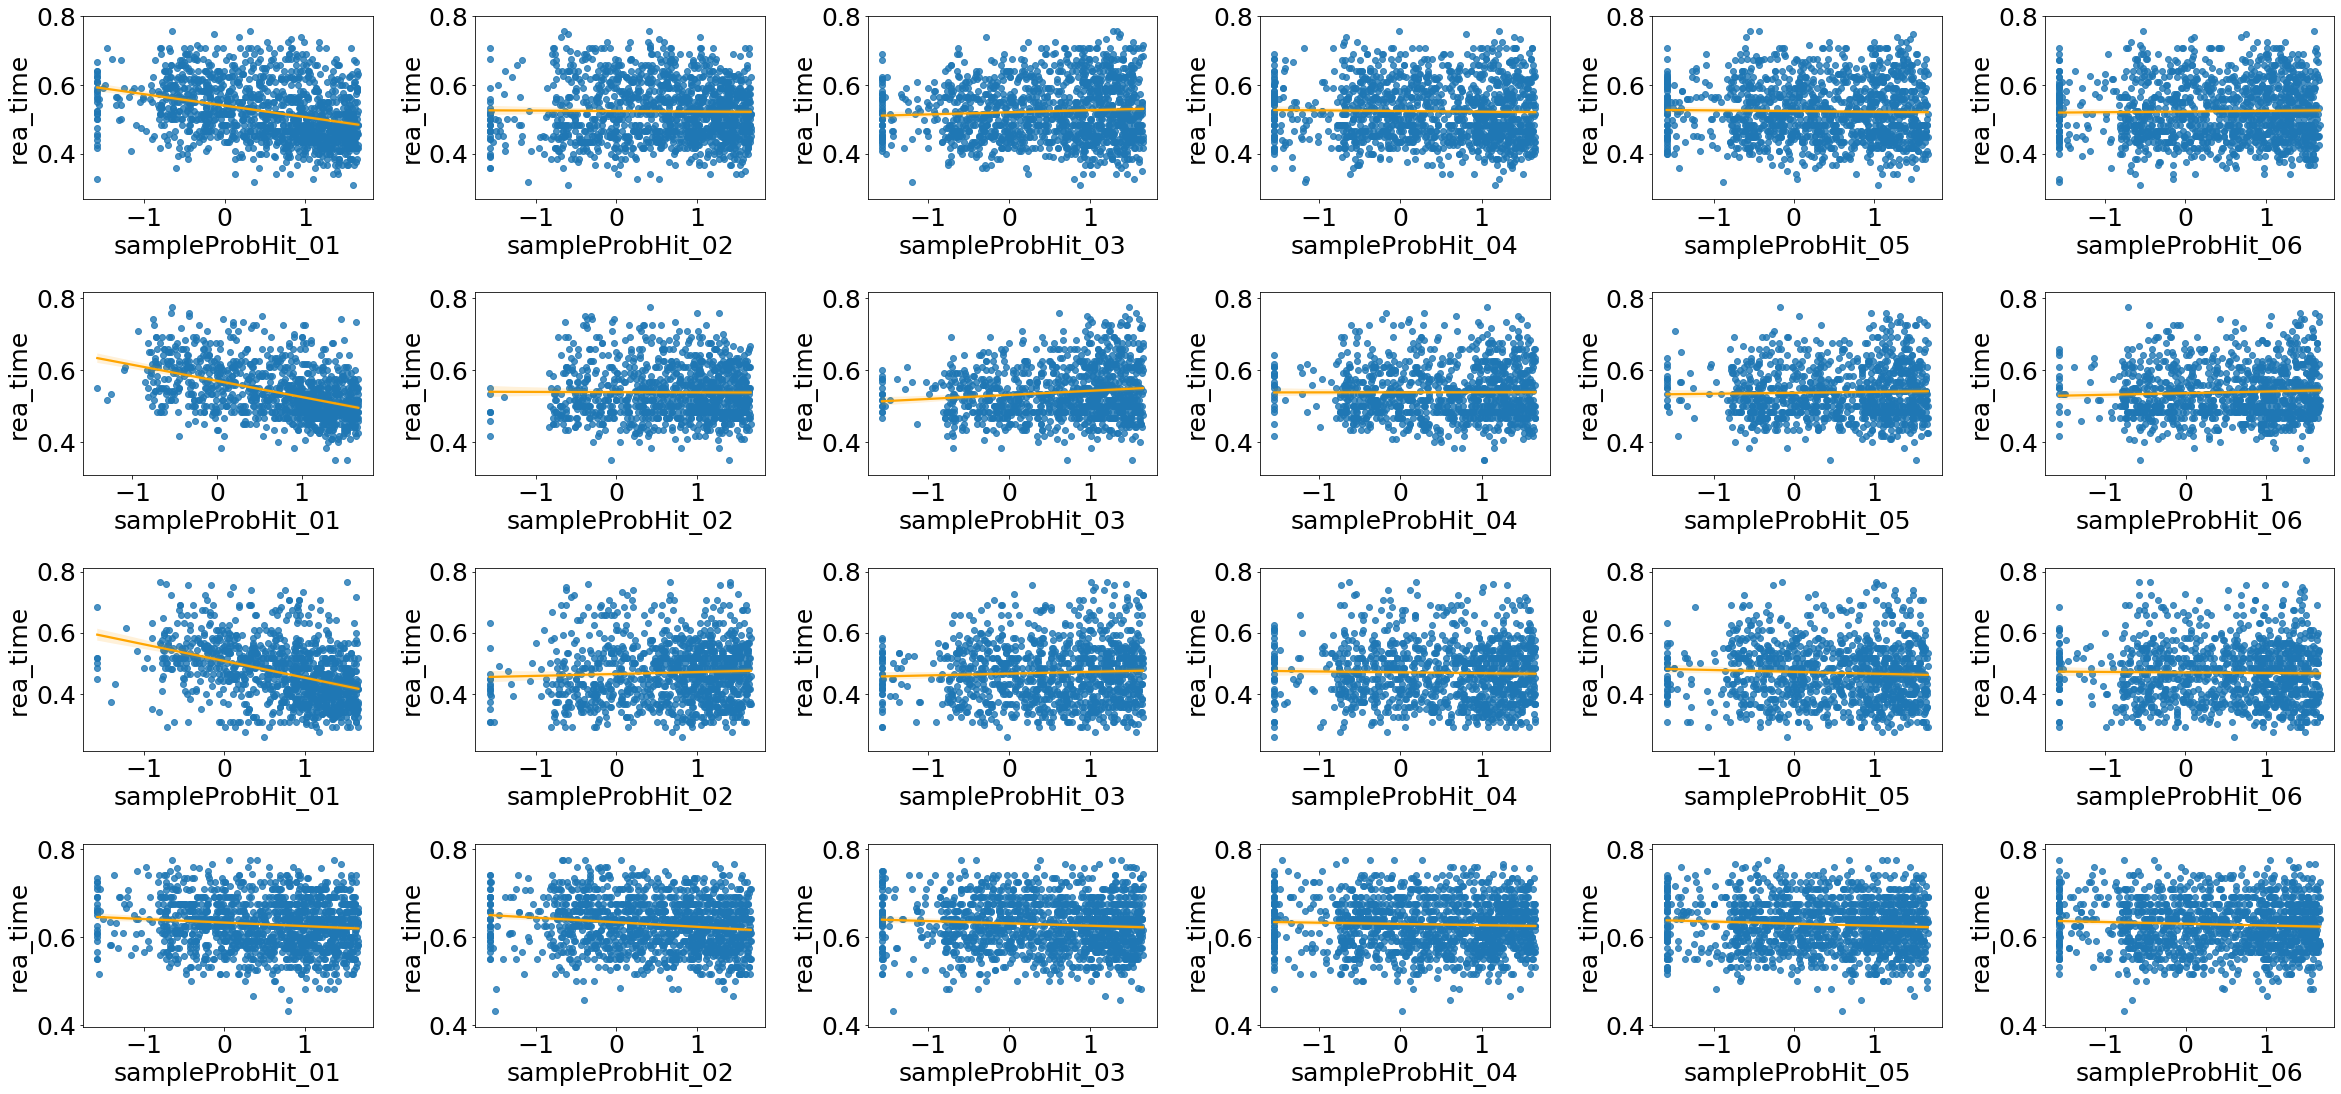

In [52]:
# visualize potential dependencies

fig_rts_visual, axs_rts_visual = plt.subplots(4,6, figsize = (6 * width + 6 * gaps, 4 * height))

for rid, s in enumerate(np.unique(normal_go.subject)):
    for cid, col in enumerate(range(1,7)):
        sb.regplot(normal_go[normal_go.subject==s]['sampleProbHit_0{}'.format(col)], normal_go[normal_go.subject == s]['rea_time'], order = 1, ax = axs_rts_visual[rid, cid], line_kws = {'color' : 'orange'})

plt.tight_layout()

Observation: the first time window shows a stronger correlation between reaction time and probability than the other windows.

In [53]:
# fit the first model

mrt_full = Lmer('rea_time ~ sampleProbHit * sampleTimeMsGo + (1 + sampleProbHit + sampleTimeMsGo|subject)', data = normal_long_go)
mrt_full.fit()

boundary (singular) fit: see ?isSingular 

Formula: rea_time~sampleProbHit*sampleTimeMsGo+(1+sampleProbHit+sampleTimeMsGo|subject)

Family: gaussian	 Inference: parametric

Number of observations: 28500	 Groups: {'subject': 4.0}

Log-likelihood: 32209.093 	 AIC: -64418.186

Random effects:

                    Name    Var    Std
subject      (Intercept)  0.005  0.067
subject    sampleProbHit  0.000  0.001
subject   sampleTimeMsGo  0.000  0.000
Residual                  0.006  0.078

                   IV1             IV2   Corr
subject    (Intercept)   sampleProbHit  0.231
subject    (Intercept)  sampleTimeMsGo  0.999
subject  sampleProbHit  sampleTimeMsGo  0.282

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.543,0.477,0.609,0.034,2.793,16.131,0.001,***
sampleProbHit,-0.006,-0.007,-0.004,0.001,2.410,-7.854,0.009,**
sampleTimeMsGo,-0.004,-0.005,-0.003,0.001,16.006,-6.527,0.000,***
sampleProbHit:sampleTimeMsGo,0.007,0.006,0.008,0.001,28482.622,11.979,0.000,***


In [54]:
# first reduction step
mrt_r1 = Lmer('rea_time ~ sampleProbHit + sampleTimeMsGo+ sampleProbHit:sampleTimeMsGo + (1|subject)', data = normal_long_go)
mrt_r1.fit()

Formula: rea_time~sampleProbHit+sampleTimeMsGo+sampleProbHit:sampleTimeMsGo+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 28500	 Groups: {'subject': 4.0}

Log-likelihood: 32208.564 	 AIC: -64417.127

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.004  0.066
Residual               0.006  0.078

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.543,0.479,0.608,0.033,3.000,16.483,0.0,***
sampleProbHit,-0.006,-0.007,-0.005,0.001,28493.094,-10.440,0.0,***
sampleTimeMsGo,-0.004,-0.005,-0.003,0.001,28493.003,-6.922,0.0,***
sampleProbHit:sampleTimeMsGo,0.007,0.006,0.008,0.001,28493.004,11.926,0.0,***


In [55]:
# first reduction step
mrt_r2 = Lm('rea_time ~ sampleProbHit + sampleTimeMsGo+ sampleProbHit:sampleTimeMsGo', data = normal_long_go)
mrt_r2.fit()

Formula: rea_time~sampleProbHit+sampleTimeMsGo+sampleProbHit:sampleTimeMsGo

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 28500	 R^2: 0.010	 R^2_adj: 0.010

Log-likelihood: 25926.458 	 AIC: -51844.916	 BIC: -51811.885

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,0.550,0.548,0.551,0.001,28496,814.565,0.0,***
sampleProbHit,-0.009,-0.011,-0.008,0.001,28496,-13.502,0.0,***
sampleTimeMsGo,-0.005,-0.006,-0.003,0.001,28496,-6.734,0.0,***
sampleProbHit:sampleTimeMsGo,0.008,0.006,0.009,0.001,28496,11.198,0.0,***


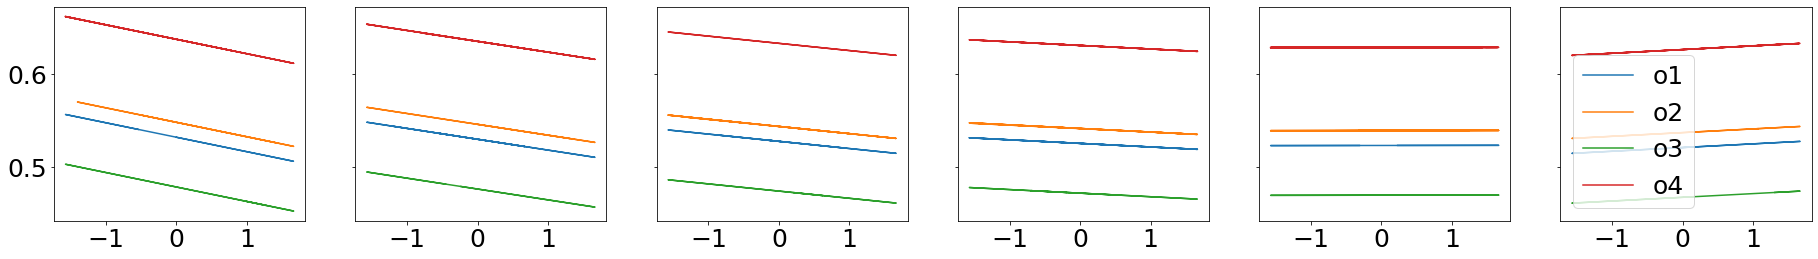

In [56]:
# Let's plot the model

fig_model_rt, axs_model_rts = plt.subplots(1, 6, figsize = (6 * width + 5 * gaps, height), sharex = True, sharey=True)

for sid, s in enumerate(np.unique(normal_long_go.subject)):
    s_df = normal_long_go[normal_long_go. subject == s]
    
    for cid, col in enumerate(np.unique(s_df.sampleID)):
        params = mrt_r1.fixef.loc[sid, :]
        samp_df = s_df[s_df.sampleID == col]
        pred_rt = params['(Intercept)'] + params['sampleProbHit']*samp_df.sampleProbHit + params['sampleTimeMsGo']*samp_df.sampleTimeMsGo + params['sampleProbHit:sampleTimeMsGo']*samp_df.sampleProbHit*samp_df.sampleTimeMsGo
        axs_model_rts[cid].plot(samp_df.sampleProbHit, pred_rt, label = s)

        
axs_model_rts[cid].legend();

Comparing these graphs to the plots above it's clear that those predictions are not accurate. That's because the slope in each plot depends on other time windows. We can avoid this issue by using the wide data format, allowing us to not impose linearity assumptions.

In [57]:
# fit reaction times in a wide format model

mwrt_1 = Lmer('rea_time ~ sampleProbHit_01 + sampleProbHit_02 + sampleProbHit_03 + sampleProbHit_04 + sampleProbHit_05 + sampleProbHit_06 + hitGoal +(1|subject)', data = normal_go)
mwrt_1.fit()

Formula: rea_time~sampleProbHit_01+sampleProbHit_02+sampleProbHit_03+sampleProbHit_04+sampleProbHit_05+sampleProbHit_06+hitGoal+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 4750	 Groups: {'subject': 4.0}

Log-likelihood: 5569.439 	 AIC: -11138.877

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.004  0.064
Residual               0.005  0.074

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.552,0.489,0.616,0.032,3.057,17.109,0.000,***
sampleProbHit_01,-0.035,-0.038,-0.032,0.002,4739.092,-22.845,0.000,***
sampleProbHit_02,-0.004,-0.007,-0.001,0.002,4739.042,-2.450,0.014,*
sampleProbHit_03,0.007,0.004,0.010,0.001,4739.006,4.428,0.000,***
sampleProbHit_04,0.001,-0.001,0.004,0.001,4739.009,1.003,0.316,
sampleProbHit_05,-0.000,-0.003,0.002,0.001,4739.014,-0.292,0.771,
sampleProbHit_06,0.003,0.000,0.006,0.001,4739.004,1.990,0.047,*
hitGoal,0.007,-0.003,0.017,0.005,4739.057,1.307,0.191,


In [58]:
# reduce the model to the significant parameters

mwrt_2 = Lmer('rea_time ~ sampleProbHit_01 + sampleProbHit_02 + sampleProbHit_03 + sampleProbHit_06 + (1|subject)', data = normal_go)
mwrt_2.fit()

Formula: rea_time~sampleProbHit_01+sampleProbHit_02+sampleProbHit_03+sampleProbHit_06+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 4750	 Groups: {'subject': 4.0}

Log-likelihood: 5583.000 	 AIC: -11166.000

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.004  0.064
Residual               0.005  0.074

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.556,0.493,0.619,0.032,3.009,17.307,0.000,***
sampleProbHit_01,-0.034,-0.037,-0.031,0.001,4742.135,-23.509,0.000,***
sampleProbHit_02,-0.003,-0.005,0.000,0.001,4742.072,-1.897,0.058,.
sampleProbHit_03,0.008,0.005,0.010,0.001,4742.039,5.758,0.000,***
sampleProbHit_06,0.004,0.001,0.006,0.001,4742.005,2.987,0.003,**


In [59]:
# reduce the model to the significant parameters

mwrt_3 = Lmer('rea_time ~ sampleProbHit_01 + sampleProbHit_03 + sampleProbHit_06 + (1|subject)', data = normal_go)
mwrt_3.fit()

Formula: rea_time~sampleProbHit_01+sampleProbHit_03+sampleProbHit_06+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 4750	 Groups: {'subject': 4.0}

Log-likelihood: 5586.851 	 AIC: -11173.702

Random effects:

                 Name    Var    Std
subject   (Intercept)  0.004  0.064
Residual               0.005  0.074

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.555,0.492,0.618,0.032,3.007,17.230,0.000,***
sampleProbHit_01,-0.034,-0.037,-0.031,0.001,4743.136,-23.532,0.000,***
sampleProbHit_03,0.007,0.005,0.010,0.001,4743.046,5.571,0.000,***
sampleProbHit_06,0.003,0.001,0.006,0.001,4743.013,2.689,0.007,**


In [60]:
# save the table with the fixed effects for this model
mwrt_3.coefs.to_csv('lmer_reactiontime.csv')

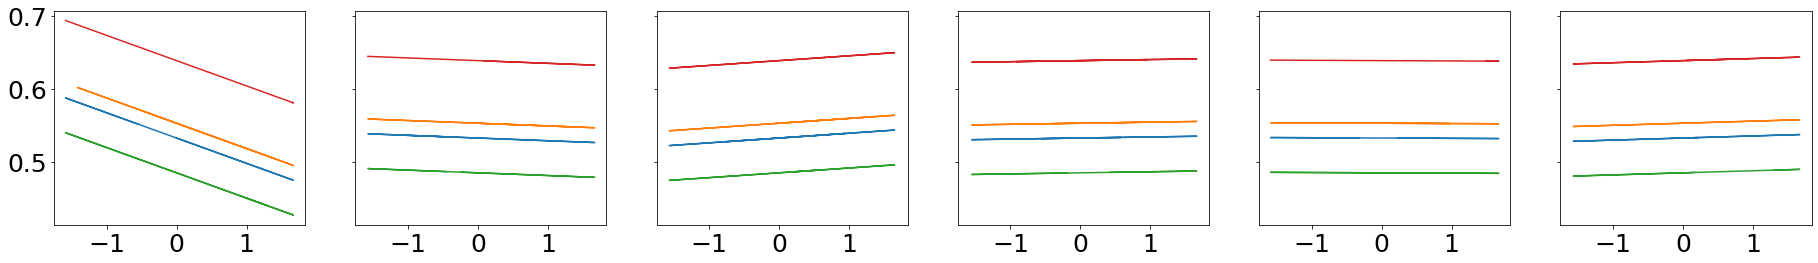

In [61]:
# visualize the correlation for each time window.

fig_rts_mw, axs_rts_mw = plt.subplots(1,6, figsize = (6 * width + 5 * gaps , height), sharex = True, sharey = True)

for sid, s in enumerate(np.unique(normal_go.subject)):
    
    s_df = normal_go[normal_go.subject == s]
    params = mwrt_1.fixef.loc[sid,:]
    
    for cid, col in enumerate(range(1,7)):
        
        tw = 'sampleProbHit_0{}'.format(col)
        pred_rt = params['(Intercept)'] + params[tw]*s_df[tw]
        
        axs_rts_mw[cid].plot(s_df[tw], pred_rt, label = s)


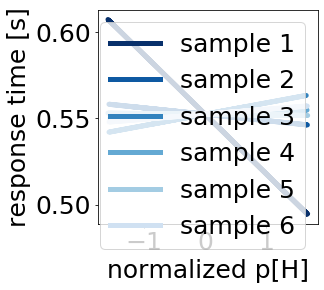

In [62]:
## make a pretty plot for the poster
# visualize potential dependencies

fig_model_rt, axs_model_rt = plt.subplots(1,1, figsize = (width* 1 , height* 1))

# for sid, s in enumerate(np.unique(normal_go.subject)):
    
#     s_df = normal_go[normal_go.subject == s]
#     params = mwrt_3.fixef.loc[sid,:]
    
#     for col, c in zip([1,3,6], t_cm[[0,1,5]]):
        
#         tw = 'sampleProbHit_0{}'.format(col)
#         pred_rt = params['(Intercept)'] + params[tw]*s_df[tw]
        
#         axs_model_rt.plot(s_df[tw], pred_rt, color = c, alpha = 0.3)

# the same for the mean of all participants

for col, c in zip([1,2,3,4,5,6], t_cm):

    tw = 'sampleProbHit_0{}'.format(col)
    pred_rt = mwrt_1.coefs.loc['(Intercept)','Estimate'] + mwrt_1.coefs.loc[tw,'Estimate']*normal_go.loc[:,tw]

    axs_model_rt.plot(normal_go[tw], pred_rt, label = 'sample {}'.format(col), color = c, linewidth = 5)
    
axs_model_rt.legend(loc = 'upper right')
axs_model_rt.set_ylabel('response time [s]')
axs_model_rt.set_xlabel('normalized p[H]')
#axs_model_rt.set_title('linear response time model');

fig_model_rt.savefig(path_figs+"LinearReactionTimes.pdf", bbox_inches='tight')
fig_model_rt.savefig(path_figs+"LinearReactionTimes.png", bbox_inches='tight')


Conclusion: the speed of the response is determined by the first presented point. strong evidence for a "go" response in the first time window results in a faster response. Weak evidence results in a slower response. However, the same behaviour cannot be ob

5. Mechanistic description

Finally, we will fit 3 different drift diffusion models as mechanistic explanations for the behaviour. 
The drift diffusion models vary in terms of their adaptability to novel information.

The first model starts drifting with the very first presented sample and does not adjust it's response after it's drift has started.

The second model only starts drifting after a given threshold for the evidence was crossed but does not change it's response after the drift has started.

The third model start drifting as soon as the first sample was presented and adjusts it's drift rate with every new sample.


We will fit these drift diffusion models using the pyDDM library written by  Maxwell Shinn, Norman H Lam and John D Murray (eLife, 2020) https://pyddm.readthedocs.io/en/latest/index.html

Drift diffusion models fitted with pyDDM have 4 core parameters that can be adjusted to accomodate custom functions. These parameters are: 
1. drift: the drift rate with which the decision value approaches the boundary
2. noise: the noise added to the drift
3. bound: the position of the boundary
4. overlay: any post-drift adaptations to the reaction time distributions.

In the models below, noise, bound and overlay will be the same, only the drift rate will be defined differently.

NOISE: the noise level will be constant throught all trials, the standart deviation will be fitted

BOUND: the bounds will collaps exponentially after a delay. The decay parameter and the delay will be fitted.

OVERLAY: a constant non-decision time is added. The value of that non decision time will be fitted.


The drift rates will be explained in detail when defined.

#### Important to note:
Fitting these models takes a long time. The specific lines that call the fit will be commented out below. 
Due to computational constraints, we will fit the drift diffusion models only to one participant for the purpose of this conference. 

As reaction times are only available for "go" responses, we only fit the response time to go-responses here.
To compare the resulting model fits to the participant, however, we need to generate no-go-responses, too. 

Here is how I will do this:

drift diffusion models track the evidence for one outcome over another. In this implementation, the upper bound represents a correct outcome, the lower bound represents an incorrect outcome therefore, we need to scale our evidence (probability of a hit) such that it reflects the similarity to the true outcome of the trial. (Large, when there is no difference between the true outcome and the evidence), 0 when it's neutral, 1 when there's evidence for the opposite outcome.

In [74]:
# set up the data frame to model the drift diffusion
# import my file
ddm_df = go_df.copy() 
ddm_full = df.copy()
# reduce to one subject
ddm_df = ddm_df[ddm_df.subject == 'o1'] 
ddm_full = ddm_full[ddm_full.subject == 'o1'] 

def get_distance(data, columns, relative_to):
    
    for column in columns:
        data.loc[:, column] = 2 * (0.5 - abs(data[relative_to]-data[column]))
    
    return data

# compute the proximity of each probability to the true outcome
ddm_df = get_distance(ddm_df, ['sampleProbHit_01','sampleProbHit_02','sampleProbHit_03',
                              'sampleProbHit_04','sampleProbHit_05','sampleProbHit_06'], 'hitGoal')

ddm_full = get_distance(ddm_full, ['sampleProbHit_01','sampleProbHit_02','sampleProbHit_03',
                                   'sampleProbHit_04','sampleProbHit_05','sampleProbHit_06'], 'hitGoal')

# reduce my data file to the neccesary columns
ddm_df = ddm_df.loc[:,['rea_time', 'answer', 'sampleProbHit_01', 'sampleProbHit_02', 'sampleProbHit_03', 'sampleProbHit_04', 'sampleProbHit_05', 'sampleProbHit_06']]

# drop all rows that contain nans and reset the index 
ddm_df.dropna(axis = 1, inplace = True)
ddm_df.reset_index(drop = True, inplace = True)

# turn my datafile into a pyDDM sample
sample = Sample.from_pandas_dataframe(ddm_df, rt_column_name="rea_time", correct_column_name="answer")


In [75]:
# step 1: define a collapsing boundary class.
# this class definition was taken from https://pyddm.readthedocs.io/en/latest/cookbook/bounds.html#bound-exp-delay

class BoundCollapsingExponentialDelay(Bound):
    """Bound collapses exponentially over time.

    Takes three parameters: 

    `B` - the bound at time t = 0.
    `tau` - the time constant for the collapse, should be greater than
    zero.
    `t1` - the time at which the collapse begins, in seconds
    """
    name = "Delayed exponential collapsing bound"
    required_parameters = ["B", "tau", "t1"]
    def get_bound(self, t, conditions, **kwargs):
        if t <= self.t1:
            return self.B
        if t > self.t1:
            return self.B * np.exp(-self.tau*(t-self.t1))

In [76]:
# step 2 define the drift classes

# the drift for the fist model
class FirstValDrift(Drift):
    """ returns the first evidence value multiplied by the scale
    
    Takes one parameter:
    
    'scale' - scales the evidence up or down to the final drift rate
    
    """
    name = "returns drift of first value"
    required_conditions = ["sampleProbHit_01"]
    required_parameters = ["scale"]
    def get_drift(self, t, conditions, **kwargs):
        return conditions['sampleProbHit_01']*self.scale
    
# the drift for the second model

class ThreshDrift(Drift):
    """ returns 0 till a threshold is crossed. Then, returns the first evidence that was above the threshold
    
    Takes two parameters:
    
    'scale' - scales the evidence up or down to the final drift rate
    'thresh' - the threshold up to which the model returns "0"
    
    """
    name = "drifts with the first value above threshold"
    required_conditions = ["sampleProbHit_01", "sampleProbHit_02", "sampleProbHit_03", "sampleProbHit_04", "sampleProbHit_05", "sampleProbHit_06"]
    required_parameters = ["scale","thresh"]
    # set a drift value here to access it later
    drift_value = 0
    # this schema defines the temporal structure how samples appeared
    time_schema = np.linspace(0, 0.88, 6)
    def get_drift(self, t, conditions, **kwargs):
        # get all samples that were already shown
        passed = self.time_schema[(self.time_schema - t)<=0]
        # get the most recent of these
        prob = self.required_conditions[np.argmax(passed)]
        # check if we have to set a drift value
        if (conditions[prob] > self.thresh) and (self.drift_value == 0):
            # set the drift value
            ThreshDrift.drift_value = conditions[prob]*self.scale
        # return the drift value
        return self.drift_value
    
    
# Define the Drift for the Third Model
class ContinuousUpdate(Drift):
    """ always returns the current evidence * scale
    
    Takes one parameter:
    
    'scale' - scales the evidence up or down to the final drift rate
    
    """
    name = "continuously updating drifts"
    required_conditions = ["sampleProbHit_01", "sampleProbHit_02", "sampleProbHit_03", "sampleProbHit_04", "sampleProbHit_05", "sampleProbHit_06"]
    required_parameters = ["scale"]
    # this schema defines the temporal structure how samples appeared
    time_schema = np.linspace(0,0.88,6)
    def get_drift(self, t, conditions, **kwargs):
        # get all samples that were already shown
        passed = self.time_schema[(self.time_schema - t)<=0]
        # get the most recent
        prob = self.required_conditions[np.argmax(passed)]
        # multiply with scale and return
        return conditions[prob]*self.scale

In [77]:
# try load the fitted models:

with open(path_models + 'ddm1_30_04.pkl', 'rb') as file:
    ddm1 = pickle.load(file)
with open(path_models + 'ddm2_30_04.pkl', 'rb') as file:
    ddm2 = pickle.load(file)
with open(path_models + 'ddm3_30_04.pkl', 'rb') as file:
    ddm3 = pickle.load(file)

In [67]:
# # define all 3 models 

# # # as long as the models are not fitted, we can use these dummies:
# # scale = 3
# # thresh = 0.3
# # noise = 1.5
# # tau = 0.2
# # t1 = 0.05
# # nondectime = 0.3


# #if not 'ddm1' in locals() or 'ddm1' in globals():

# if True:

#     ## model one: immediate contant drift
#     ddm1 = Model(name='drift rate depends on first tw (fitted)',
#                  # custom, fittable drift rate
#                  #drift= FirstValDrift(scale = Fittable(minval=1, maxval=10)),
#                  drift= FirstValDrift(scale = scale),
#                  # constant, fittable noise
#                  #noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
#                  noise=NoiseConstant(noise = noise),
#                  # custom, fittable boundary
#                  #bound=BoundCollapsingExponentialDelay(B=1,
#                                                        #tau=Fittable(minval=0.1, maxval=5),
#                                                        #t1=Fittable(minval=0, maxval=1)),
#                  bound=BoundCollapsingExponentialDelay(B=1,
#                                                        tau=tau,
#                                                        t1=t1),
#                  # constant, fittable non-decision time
#                  #overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
#                  overlay=OverlayNonDecision(nondectime=nondectime),
#                  dx=.001, dt=.01, T_dur=1)


# #if not 'ddm2' in locals() or 'ddm2' in globals():
# if True:
#     ## model two: delayed drift with threshold
#     ddm2 = Model(name='drift starts after threshold was crossed',
#                  # custom, fittable drift rate
#                  #drift= ThreshDrift(scale = Fittable(minval=1, maxval=10),thresh = Fittable(minval = 0.1, maxval = 1)),
#                  drift= ThreshDrift(scale = scale ,thresh = thresh),
#                  # constant, fittable noise
#                  noise=NoiseConstant(noise=noise),
#                  #noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
#                  # custom, fittable boundary
#                  #bound=BoundCollapsingExponentialDelay(B=1,
#                  #                                      tau=Fittable(minval=0.1, maxval=5),
#                  #                                      t1=Fittable(minval=0, maxval=1)),
#                  bound=BoundCollapsingExponentialDelay(B=1,
#                                                        tau=tau,
#                                                        t1=t1),
#                  # constant, fittable non-decision time
#                  #overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
#                  overlay=OverlayNonDecision(nondectime=nondectime),
#                  dx=.001, dt=.01, T_dur=1)

# #if not 'ddm3' in locals() or 'ddm3' in globals():
# if True:
#     ## model three: drift according to the the lastest sample
#     ddm3 = Model(name='drift changes with every new sample',
#                  # custom, fittable drift rate
#                  #drift= ContinuousUpdate(scale = Fittable(minval=1, maxval=10)),
#                  drift= ContinuousUpdate(scale = scale),
#                  # constant, fittable noise
#                  #noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
#                  noise=NoiseConstant(noise=noise),
#                  # custom, fittable boundary
# #                  bound=BoundCollapsingExponentialDelay(B=1,
# #                                                        tau=Fittable(minval=0.1, maxval=5),
# #                                                        t1=Fittable(minval=0, maxval=1)),
#                  bound=BoundCollapsingExponentialDelay(B=1,
#                                                        tau=tau,
#                                                        t1=t1),
#                  # constant, fittable non-decision time
#                  overlay=OverlayNonDecision(nondectime=nondectime),
#                  #overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
#                  dx=.001, dt=.01, T_dur=1)

In [68]:
#fit_adjust_model(sample, ddm1, lossfunction=LossRobustBIC, verbose=False)
#fit_adjust_model(sample, ddm2, lossfunction=LossRobustBIC, verbose=False)
#fit_adjust_model(sample, ddm3, lossfunction=LossRobustBIC, verbose=False)

#with open(path_models + 'ddm1.pkl', 'wb') as output:
#    pickle.dump(ddm1, output, pickle.HIGHEST_PROTOCOL)
#with open(path_models + 'ddm2.pkl', 'wb') as output:
#    pickle.dump(ddm2, output, pickle.HIGHEST_PROTOCOL)
#with open(path_models + 'ddm3.pkl', 'wb') as output:
#    pickle.dump(ddm3, output, pickle.HIGHEST_PROTOCOL)

In [78]:
obs_file = ddm_full.copy()
m1_df = obs_file.copy()
m2_df = obs_file.copy()
m3_df = obs_file.copy()

## solve the models for every trial, get an estimate of the response time, and of a true/false answer
# finally, get the answer by comparing true/false to the condition
m1_df['probAnswer'] = np.nan
m2_df['probAnswer'] = np.nan
m3_df['probAnswer'] = np.nan


for r in obs_file.index:

    conditions = {
        'sampleProbHit_01': obs_file.loc[r, 'sampleProbHit_01'],
        'sampleProbHit_02': obs_file.loc[r, 'sampleProbHit_02'],
        'sampleProbHit_03': obs_file.loc[r, 'sampleProbHit_03'],
        'sampleProbHit_04': obs_file.loc[r, 'sampleProbHit_04'],
        'sampleProbHit_05': obs_file.loc[r, 'sampleProbHit_05'],
        'sampleProbHit_06': obs_file.loc[r, 'sampleProbHit_06'],
        
    }

    ddm1Solution = ddm1.solve(conditions = conditions)
    ddm2Solution = ddm2.solve(conditions = conditions)
    ddm3Solution = ddm3.solve(conditions = conditions)
    

    m1_df.loc[r,'rea_time'] = ddm1Solution.resample(1) 
    m1_df.loc[r,'probAnswer'] = ddm1Solution.prob_correct()

    m2_df.loc[r,'rea_time'] =  ddm2Solution.resample(1)
    m2_df.loc[r,'probAnswer'] =  ddm2Solution.prob_correct()
    
    m3_df.loc[r,'rea_time'] =  ddm3Solution.resample(1)
    m3_df.loc[r,'probAnswer'] =  ddm3Solution.prob_correct()

m1_df.loc[:,'answer'] = np.round(m1_df.probAnswer)
m2_df.loc[:,'answer'] = np.round(m2_df.probAnswer)
m3_df.loc[:,'answer'] = np.round(m3_df.probAnswer)

m1_df.loc[:,'goResp'] = 1 - (abs(m1_df.answer - m1_df.hitGoal))
m2_df.loc[:,'goResp'] = 1 - (abs(m2_df.answer - m2_df.hitGoal))
m3_df.loc[:,'goResp'] = 1 - (abs(m3_df.answer - m3_df.hitGoal))

Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather 

In [79]:
# get response types

for ix in m1_df.index:
    if m1_df.loc[ix,'goResp'] == 1:
        if m1_df.loc[ix,'hitGoal'] == 1:
            m1_df.loc[ix,'response_cat'] = 'HIT'
        else:
            m1_df.loc[ix,'response_cat'] = 'FALSE ALARM'
    else:
        if m1_df.loc[ix,'hitGoal'] == 1:
            m1_df.loc[ix,'response_cat'] = 'MISS'
        else:
            m1_df.loc[ix,'response_cat'] = 'CORRECT REJECTION'

for ix in m2_df.index:
    
    if m2_df.loc[ix,'goResp'] == 1:
        if m2_df.loc[ix,'hitGoal'] == 1:
            m2_df.loc[ix,'response_cat'] = 'HIT'
        else:
            m2_df.loc[ix,'response_cat'] = 'FALSE ALARM'
    else:
        if m2_df.loc[ix,'hitGoal'] == 1:
            m2_df.loc[ix,'response_cat'] = 'MISS'
        else:
            m2_df.loc[ix,'response_cat'] = 'CORRECT REJECTION'
            
for ix in m3_df.index:
    
    if m3_df.loc[ix,'goResp'] == 1:
        if m3_df.loc[ix,'hitGoal'] == 1:
            m3_df.loc[ix,'response_cat'] = 'HIT'
        else:
            m3_df.loc[ix,'response_cat'] = 'FALSE ALARM'
    else:
        if m3_df.loc[ix,'hitGoal'] == 1:
            m3_df.loc[ix,'response_cat'] = 'MISS'
        else:
            m3_df.loc[ix,'response_cat'] = 'CORRECT REJECTION'
            

In [80]:
obs_file

,goalPosDegCen,difficulty,in_out,up_down,samplePosDegCen_01,samplePosDegCen_02,samplePosDegCen_03,samplePosDegCen_04,samplePosDegCen_05,samplePosDegCen_06,...,sampleAccprobHit_06,sampleProbHit_01,sampleProbHit_02,sampleProbHit_03,sampleProbHit_04,sampleProbHit_05,sampleProbHit_06,answer,p_on_move,lastAccprobHit
0,2,1.809975,1,-1,0.301258,3.225335,2.362545,1.703039,-0.261664,0.700806,...,0.213758,0.027808,0.758827,0.543130,0.378254,-0.112922,0.127695,0,2.0,0.190052
1,2,1.847432,-1,-1,-0.822462,5.460380,5.465482,0.879874,-0.565124,2.491225,...,1.000000,0.832526,-0.403237,-0.404513,0.741890,0.896861,0.339052,1,2.0,1.000000
2,2,1.929658,-1,1,3.746282,0.868587,-1.166560,-1.477911,1.467197,5.791083,...,1.000000,0.918985,0.199561,-0.309226,-0.387063,0.349214,0.569815,1,2.0,0.895029
3,-2,1.834521,-1,-1,-3.330029,-0.337660,0.971259,1.627050,-5.873847,1.302279,...,1.000000,0.791138,0.043045,-0.284184,-0.448132,0.572908,-0.366939,1,3.0,0.725445
4,4,1.920750,1,1,4.869227,3.625997,5.868832,5.287595,5.330901,2.434693,...,0.112562,0.262881,0.573688,0.012979,0.158289,0.147462,0.871514,0,2.0,0.296196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2394,2,1.956829,-1,1,0.673330,-0.605403,-0.369836,5.425809,2.327527,3.288999,...,1.000000,0.157540,-0.162143,-0.103252,0.654341,0.571089,0.811457,1,2.0,0.498630
2395,0,1.959204,-1,1,1.060225,1.914454,-0.831603,-2.215298,1.369754,-1.550037,...,0.967356,0.754857,0.968415,0.281900,-0.064023,0.832240,0.102292,1,2.0,0.975953
2396,2,1.967225,-1,-1,5.362199,5.502438,-1.081612,-0.101259,3.652739,3.882380,...,1.000000,-0.348743,-0.383803,0.737791,0.982879,0.078622,0.021211,1,3.0,1.000000
2397,4,1.800135,-1,-1,7.109155,7.792877,4.805693,6.505984,2.162851,0.934221,...,1.000000,-0.327255,-0.498186,0.248610,-0.176462,0.909321,0.783522,1,4.0,0.846953


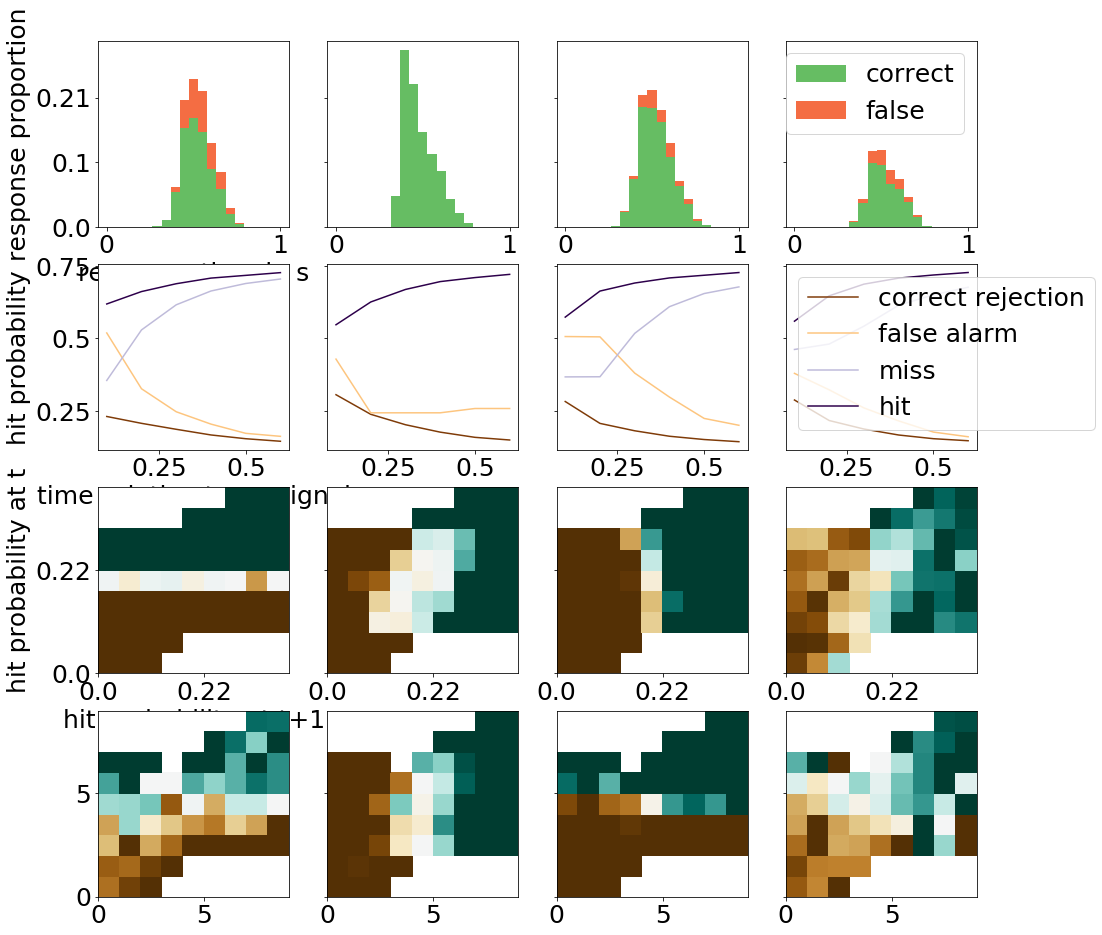

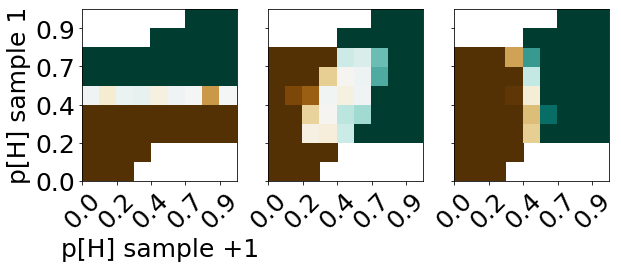

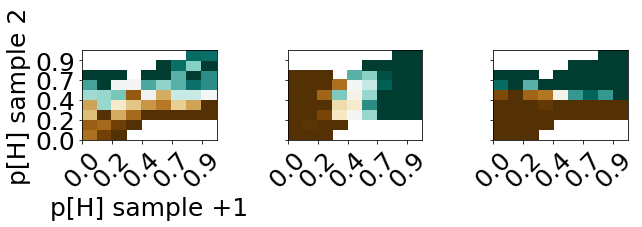

In [81]:
# make one large plot to compare the model predicitions to the actual data.
f2, a2 = plt.subplots(4,4, figsize = (width * 4 , height * 4), sharex = 'row', sharey = 'row')

VSS2021_modelPredW1, axs_predictionW1 = plt.subplots(1,3, figsize = (width *3 * 0.8, height* 0.8), sharex = True, sharey = True)
VSS2021_modelPredW2, axs_predictionW2 = plt.subplots(1,3, figsize = (width *3 * 0.8, height* 0.8), sharex = True, sharey = True)

# define the bins for count plots
bins = np.linspace(0,1,20)

# define response types
responses = ['CORRECT REJECTION', 'FALSE ALARM', 'MISS', 'HIT']

# define probability windows
n_pwins = 10
window_prob = np.linspace(min(obs_file.sampleAccprobHit_01),max(obs_file.sampleAccprobHit_01),n_pwins)

for m_id, m_df in enumerate([m1_df.loc[obs_file.index,:], m2_df.loc[obs_file.index,:], m3_df.loc[obs_file.index,:], obs_file]):

    # first plot: distribution correct & incorrect reaction times
    # filter correct and incorrect reaction times
    RTs_c = m_df[m_df.answer == 1].rea_time
    RTs_i = m_df[m_df.answer == 0].rea_time

    # get histograms
    #CountRTs_c = np.histogram(RTs_c[~np.isnan(RTs_c)], bins = bins)[0]
    #CountRTs_i = -1 *np.histogram(RTs_i[~np.isnan(RTs_i)], bins = bins)[0]
    
    # plot everything
    #a2[1,m_id].bar(bins[:-1],CountRTs_c, color = p_cm(0.8))
    #a2[1,m_id].bar(bins[:-1],CountRTs_i, color = p_cm(0.2))
    a2[0,m_id].hist([RTs_c[~np.isnan(RTs_c)],RTs_i[~np.isnan(RTs_i)]], bins= bins, stacked = True, color = p_cm([0.8, 0.2]), label = ['correct', 'false'])# bins = bins
    #

    # second plot: mean hit probabilities before each response
    # initialize data frames
    value_respcat_fw = pd.DataFrame()
    
    # time information relative to go response
    for timewin in range(1,7):
        
        time_col = 'sampleAccprobHit_0{}'.format(timewin)

        # loop through response categories
        for respcat in responses:
            # get mean probability for category and time value
            value_respcat_fw.loc[respcat, timewin] = (np.mean(m_df.loc[m_df.response_cat == respcat,time_col])/2)+0.5
            
    # plot
    for row, c in zip(responses, c_cm(np.linspace(0, 1, len(responses)))):
        a2[1, m_id].plot(range(1,7),value_respcat_fw.loc[row,:], label = row.lower(), color = c)
        
    
    ## third plot: reproduce the decision after evidence pattern
    # translate df into long data frame
    
    # in order to match the trials later, we want an ID
    m_df['ids'] = m_df.index
    # melt the data frame into long format
    long_m_df = m_df.melt(id_vars=['goResp', 'hitGoal', 'ids'], value_vars=['sampleAccprobHit_01','sampleAccprobHit_02','sampleAccprobHit_03','sampleAccprobHit_04','sampleAccprobHit_05','sampleAccprobHit_06'], var_name='sampleID', value_name='sampleAccprobHit')

    
    for tWin in [1,2]:
        # define a panda data frame to store the values:
        # intitialize the data frames
        change_fw = pd.DataFrame()

        # filter data from this tw
        ctw_fw = long_m_df[long_m_df.sampleID == 'sampleAccprobHit_0{}'.format(tWin)]

        # filter data from the next tw
        ntw_fw = long_m_df[long_m_df.sampleID == 'sampleAccprobHit_0{}'.format(tWin + 1)]

        # go through all probabilites in tw 1
        for p_start in range(0, n_pwins-1):

            pst_low =  window_prob[p_start]
            pst_up = window_prob[p_start + 1]

            # get all IDs that fullfill the trial 
            start_IDs_fw = ctw_fw.iloc[np.where((ctw_fw.sampleAccprobHit >= pst_low)&(ctw_fw.sampleAccprobHit < pst_up))[0]]['ids']

            # go through all probabilities in the next time window
            for p_end in range(0, n_pwins-1):

                pend_low =  window_prob[p_end]
                pend_up = window_prob[p_end + 1]

                # get all ids that fullfill the end probability requirement
                end_IDs_fw = ntw_fw.iloc[np.where((ntw_fw.sampleAccprobHit >= pend_low)&(ntw_fw.sampleAccprobHit < pend_up))[0]]['ids']

                # get the intercept between the two lists
                ID_list_fw = np.intersect1d(start_IDs_fw, end_IDs_fw)


                # filter the dataframe
                df_fw = long_m_df.loc[np.where(long_m_df.ids.isin(ID_list_fw))]


                change_fw.loc[window_prob[p_start],window_prob[p_end]] = np.mean(df_fw.goResp)

        # plot
        a2[1+tWin,m_id].pcolormesh(change_fw, cmap = g_cm)
        if m_id <= 2:
            if tWin == 1:
                axs_predictionW1[m_id].pcolormesh(change_fw, cmap = g_cm)
            else:
                axs_predictionW2[m_id].pcolormesh(change_fw, cmap = g_cm)

    
# Use absolute value for y-ticks
# change the axis ticks
ticks =  a2[0,0].get_yticks()
a2[0,0].set_yticklabels([np.round(abs(tick/len(m_df)),2) for tick in ticks]);
a2[0,3].legend()
a2[0,0].set_ylabel('response proportion')
a2[0,0].set_xlabel('response time in s')


a2[1,3].legend()
a2[1,0].set_ylabel('hit probability')
ticks =  a2[1,0].get_xticks()
a2[1,0].set_xticklabels([tick/10 for tick in ticks]);
a2[1,0].set_yticklabels(np.linspace(0, 1, 5));

a2[1,0].set_xlabel('time relative to go signal')


a2[2,1].set_yticklabels(np.round(change_fw.columns, 2)[::2])
a2[2,1].set_xticklabels(np.round(change_fw.index, 2)[[0, 2, 5, 7]]);
a2[2,0].set_ylabel('hit probability at t')
a2[2,0].set_xlabel('hit probability at t+1')

# set the axis for individual figures
#print(window_prob)

axs_predictionW1[0].set_yticks(np.arange(0,10,2))
axs_predictionW1[0].set_yticklabels(np.round(window_prob,1)[::2])

axs_predictionW1[0].set_xticks(np.arange(0,10,2))
axs_predictionW1[0].set_xticklabels(np.round(window_prob,1)[::2], rotation = 45)
axs_predictionW1[1].set_xticklabels(np.round(window_prob,1)[::2], rotation = 45)
axs_predictionW1[2].set_xticklabels(np.round(window_prob,1)[::2], rotation = 45)

axs_predictionW2[0].set_yticks(np.arange(0,10,2))
axs_predictionW2[0].set_yticklabels(np.round(window_prob,1)[::2])

axs_predictionW2[0].set_xticks(np.arange(0,10,2))
axs_predictionW2[0].set_xticklabels(np.round(window_prob,1)[::2], rotation = 45)
axs_predictionW2[1].set_xticklabels(np.round(window_prob,1)[::2], rotation = 45)
axs_predictionW2[2].set_xticklabels(np.round(window_prob,1)[::2], rotation = 45)

axs_predictionW1[0].set_ylabel('p[H] sample 1')
axs_predictionW1[0].set_xlabel('p[H] sample +1')

axs_predictionW2[0].set_ylabel('p[H] sample 2')
axs_predictionW2[0].set_xlabel('p[H] sample +1')

VSS2021_modelPredW1.savefig(path_figs + 'ddmPredicitions_win1.pdf', bbox_inches = 'tight')
VSS2021_modelPredW2.savefig(path_figs + 'ddmPredicitions_win2.pdf', bbox_inches = 'tight')

plt.tight_layout()

f2.savefig(path_figs+"ddmComparison.pdf", bbox_inches='tight')
f2.savefig(path_figs+"ddmComparison.png", bbox_inches='tight')
